# Installs

In [ ]:
!pip install transformers --q
!pip install torch --q
!pip install einops --q
!pip install biopython --q
!pip install shap --q
!pip install nlp --q

# Imports

In [ ]:
from Bio import SeqIO
import torch
from transformers import AutoTokenizer, AutoModel
import random
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import random_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict
import pickle
from transformers import TFBertForSequenceClassification
from transformers import OpenAIGPTConfig, OpenAIGPTModel
import torch
import pandas as pd
from tokenizers import Tokenizer
from tokenizers.models import BPE, Unigram, WordLevel, WordPiece
from tokenizers.trainers import BpeTrainer, WordLevelTrainer,WordPieceTrainer, UnigramTrainer
from tokenizers.pre_tokenizers import Sequence, Digits, Whitespace
from transformers import PreTrainedTokenizerFast
import random
from tokenizers import Tokenizer, models, trainers
from transformers import BertConfig, BertForSequenceClassification, DataCollatorForLanguageModeling, Trainer, TrainingArguments
from torch.nn.utils.rnn import pad_sequence
from transformers import AutoTokenizer, BertForMaskedLM
import pandas as pd
from transformers import BertTokenizer, BertForMaskedLM
from torch.utils.data import Dataset, DataLoader
from transformers import BertConfig, BertForMaskedLM
from tqdm import tqdm
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertModel , RobertaTokenizer, TFRobertaModel , AutoTokenizer, AutoModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from transformers import RobertaForMaskedLM, RobertaTokenizer, RobertaTokenizerFast, RobertaConfig
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, trainers, processors
from transformers import RobertaForSequenceClassification
import shap
import torch
from transformers import AdamW, RobertaForSequenceClassification
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import MultiStepLR
import os
from sklearn.metrics import confusion_matrix
import json

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data for Tokenizer and Masking model

In [ ]:
all_data_pos = pd.read_csv('data/all_data_combined_df.csv', index_col = False)
all_data_pos['True_label']=1

train_df, validation_df = train_test_split(all_data_pos, test_size=0.2, random_state=42)

In [ ]:
#this will be used for training the tokenizers
df_sequences = all_data_pos['seq'].tolist()
df_labels = all_data_pos['True_label'].tolist()

#this will be used for the pre-train(masking)
df_train_sequences = train_df['seq'].tolist()
df_train_labels = train_df['True_label'].tolist()

df_val_sequences = validation_df['seq'].tolist()
df_val_labels = validation_df['True_label'].tolist()

# Tokenizer K-MER

In [ ]:
UNK_TOKEN = "[UNK]"
SPL_TOKENS = ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]

def batch_iterator(dataset, batch_size=10000):
    """
    Creates an iterator that yields batches of data from the dataset.

    Args:
        dataset (list): The dataset to be batched.
        batch_size (int): The size of each batch (default is 10000).

    Yields:
        list: A batch of data from the dataset.
    """
    for i in range(0, len(dataset), batch_size):
        yield dataset[i: i + batch_size]

def create_fixed_length_tokens(sequences, token_length=6):
    """
    Splits sequences into fixed-length tokens.

    Args:
        sequences (list of str): List of sequences to be tokenized.
        token_length (int): The length of each token (default is 6).

    Returns:
        list of str: List of tokenized sequences where each sequence is a string of tokens separated by spaces.
    """
    results = []
    for amino in sequences:
        tokens = [amino[i:i+token_length] for i in range(0, len(amino), token_length)]
        results.append(' '.join(tokens))
    return results

def train_biological_tokenizer(vocab_size):
    """
    Trains a tokenizer on biological sequences.

    Args:
        vocab_size (int): The size of the vocabulary for the tokenizer.

    Returns:
        Tokenizer: The trained tokenizer.
    """
    X_train = df_sequences
    y_train = df_labels

    X_train = create_fixed_length_tokens(X_train, token_length=6)

    tokenizer = Tokenizer(WordLevel(unk_token=UNK_TOKEN))
    trainer = WordLevelTrainer(vocab_size=vocab_size, special_tokens=SPL_TOKENS)
    tokenizer.pre_tokenizer = Whitespace()

    tokenizer.train_from_iterator(batch_iterator(X_train), trainer)  # Training the tokenizer

    return tokenizer

In [ ]:
# Train the tokenizer
tokenizer = train_biological_tokenizer(10000)

len(tokenizer.get_vocab())

In [ ]:
def encode_single_sequence(sequence, token_length=6):
      """
    Encodes a single sequence into fixed-length tokens.

    Args:
        sequence (str): The sequence to be tokenized.
        token_length (int): The length of each token (default is 6).

    Returns:
        str: The tokenized sequence as a string of tokens separated by spaces.
    """
    tokenized_sequence = create_fixed_length_tokens([sequence], token_length)[0]
    return tokenized_sequence

In [ ]:
roberta_tokenizer = RobertaTokenizerFast(tokenizer_object=tokenizer, pad_token="[PAD]")

In [ ]:
roberta_tokenizer.save_pretrained("models/kmer_tokenizer")

('models/kmer_tokenizer/tokenizer_config.json',
 'models/kmer_tokenizer/special_tokens_map.json',
 'models/kmer_tokenizer/vocab.json',
 'models/kmer_tokenizer/added_tokens.json',
 'models/kmer_tokenizer/tokenizer.json')

# Masking Model - KMER

Dataset class - only for masking model

In [ ]:
# Function to encode a single sequence
def encode_single_sequence(sequence, token_length=6):
    """
    Encodes a single DNA sequence into fixed-length tokens.

    Args:
        sequence (str): The DNA sequence to be tokenized.
        token_length (int): The length of each token (default is 6).

    Returns:
        str: The tokenized sequence as a string of tokens separated by spaces.
    """
    tokenized_sequence = create_fixed_length_tokens([sequence], token_length)[0]
    return tokenized_sequence

class DNADataset(Dataset):
    def __init__(self, sequences, tokenizer, max_length=6):
      """
    A custom dataset class for DNA sequences, designed to be used with PyTorch's DataLoader.

    Args:
        sequences (list of str): List of DNA sequences.
        tokenizer (RobertaTokenizerFast): Tokenizer to process the DNA sequences.
        max_length (int): Maximum length for tokenized sequences (default is 6).
    """
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.sequences = [encode_single_sequence(seq, 6) for seq in sequences]


    def __len__(self):
        """
        Returns the number of sequences in the dataset.

        Returns:
            int: Number of sequences.
        """
        return len(self.sequences)

    def __getitem__(self, idx):
        """
        Retrieves the tokenized inputs and label for a given index.

        Args:
            idx (int): Index of the sequence to retrieve.

        Returns:
            dict: A dictionary containing tokenized inputs and the label.
        """
        sequence = self.sequences[idx]
        inputs = self.tokenizer(
            sequence,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        inputs = {key: val.squeeze(0) for key, val in inputs.items()}  # Remove batch dimension
        inputs['labels'] = inputs['input_ids'].clone()
        return inputs

Dataloaders from positive data

In [ ]:
# Create a dataset object
train_dataset = DNADataset(df_train_sequences, tokenizer = roberta_tokenizer)
validation_dataset = DNADataset(df_val_sequences, tokenizer = roberta_tokenizer)

# Create a dataloader
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

Model configuration

In [ ]:
# Define model configuration
config = RobertaConfig(
    vocab_size=roberta_tokenizer.vocab_size,
    max_position_embeddings=514,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1,
    pad_token_id=roberta_tokenizer.pad_token_id,
    bos_token_id=roberta_tokenizer.bos_token_id,
    eos_token_id=roberta_tokenizer.eos_token_id
)

# Initialize the model
model = RobertaForMaskedLM(config)

Training loop

In [ ]:
# Define training parameters
num_epochs = 2
learning_rate = 1e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
train_history=[]
val_history=[]

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for i, batch in enumerate(train_dataloader):
        inputs = {key: val.to(model.device) for key, val in batch.items()}
        outputs = model(**inputs)
        loss = outputs.loss

        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if i>0 and i % 300 ==0:
            print(f"Epoch {epoch+1}/{num_epochs}, Iteration {i}, Training Loss: {total_loss/i:.4f}")

    avg_loss = total_loss / len(train_dataloader)
    train_history.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_loss:.4f}")

    # Validation
    model.eval()
    with torch.no_grad():
        val_losses = []
        for val_batch in validation_dataloader:
            val_inputs = {key: val.to(model.device) for key, val in val_batch.items()}
            val_outputs = model(**val_inputs)
            val_loss = val_outputs.loss
            val_losses.append(val_loss.item())

        avg_val_loss = sum(val_losses) / len(val_losses)
        val_history.append(avg_val_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_val_loss:.4f}")

/home/linago/.conda/envs/lina_env/lib/python3.11/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 1/2, Iteration 300, Training Loss: 7.8474
Epoch 1/2, Iteration 600, Training Loss: 6.9025
Epoch 1/2, Iteration 900, Training Loss: 6.0409
Epoch 1/2, Iteration 1200, Training Loss: 5.2862
Epoch 1/2, Iteration 1500, Training Loss: 4.6590
Epoch 1/2, Iteration 1800, Training Loss: 4.1391
Epoch 1/2, Iteration 2100, Training Loss: 3.7081
Epoch 1/2, Iteration 2400, Training Loss: 3.3494
Epoch 1/2, Iteration 2700, Training Loss: 3.0489
Epoch 1/2, Iteration 3000, Training Loss: 2.7940
Epoch 1/2, Iteration 3300, Training Loss: 2.5763
Epoch 1/2, Iteration 3600, Training Loss: 2.3883
Epoch 1/2, Iteration 3900, Training Loss: 2.2250
Epoch 1/2, Iteration 4200, Training Loss: 2.0816
Epoch 1/2, Iteration 4500, Training Loss: 1.9551
Epoch 1/2, Iteration 4800, Training Loss: 1.8426
Epoch 1/2, Iteration 5100, Training Loss: 1.7419
Epoch 1/2, Iteration 5400, Training Loss: 1.6513
Epoch 1/2, Iteration 5700, Training Loss: 1.5694
Epoch 1/2, Iteration 6000, Training Loss: 1.4951
Epoch 1/2, Iteration 63

Save model if needed

In [ ]:
# model.save_pretrained("models/kmer_masking_model")

# Fine Tune K-MER

In [ ]:
results_dict = defaultdict(dict)

Data for finetuning - **Substitution**

In [ ]:
train_tata = pd.read_csv("data_exp1/train_tata_met_2.csv", index_col = False)
val_tata = pd.read_csv("data_exp1/val_tata_met_2.csv", index_col = False)
test_tata = pd.read_csv('data_exp1/test_tata_met_2.csv', index_col = False)

train_non_tata = pd.read_csv('data_exp1/train_non_tata_met_2.csv', index_col = False)
val_non_tata = pd.read_csv('data_exp1/val_non_tata_met_2.csv', index_col = False)
test_non_tata = pd.read_csv('data_exp1/test_non_tata_met_2.csv', index_col = False)

In [ ]:
train = pd.concat([train_tata, train_non_tata])
val = pd.concat([val_tata, val_non_tata])
test = pd.concat([test_tata, test_non_tata])

Data for finetuning - **Genome**

In [ ]:
# train = pd.read_csv("data_exp2/train_exp2.csv", index_col = False)
# val = pd.read_csv("data_exp2/val_exp2.csv", index_col = False)
# test_tata = pd.read_csv('data_exp2/test_tata_exp2.csv', index_col = False)
# test_non_tata = pd.read_csv('data_exp2/test_non_tata_exp2.csv', index_col = False)

# test = pd.concat([test_tata, test_non_tata])

Dataset class for Fine Tune

In [ ]:
# Function to encode a single sequence
def encode_single_sequence(sequence, token_length=6):
    """
    Encodes a single DNA sequence into fixed-length tokens.

    Args:
        sequence (str): The DNA sequence to be tokenized.
        token_length (int): The length of each token (default is 6).

    Returns:
        str: The tokenized sequence as a string of tokens separated by spaces.
    """
    tokenized_sequence = create_fixed_length_tokens([sequence], token_length)[0]
    return tokenized_sequence


class DNAClassificationDataset(Dataset):
    def __init__(self, sequences, labels, tokenizer, max_length=128):
    """
    A custom dataset class for DNA classification tasks, designed to be used with PyTorch's DataLoader.

    Args:
        sequences (list of str): List of DNA sequences.
        labels (list of int): List of labels corresponding to the DNA sequences.
        tokenizer (RobertaTokenizerFast): Tokenizer to process the DNA sequences.
        max_length (int): Maximum length for tokenized sequences (default is 128).
    """
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.sequences = [encode_single_sequence(seq, 6) for seq in sequences]


    def __len__(self):
        """
        Returns the number of sequences in the dataset.

        Returns:
            int: Number of sequences.
        """
        return len(self.sequences)

    def __getitem__(self, idx):
        """
        Retrieves the tokenized inputs and label for a given index.

        Args:
            idx (int): Index of the sequence to retrieve.

        Returns:
            dict: A dictionary containing tokenized inputs and the label.
        """
        sequence = self.sequences[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(
            sequence,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        inputs = {key: val.squeeze(0) for key, val in inputs.items()}  # Remove batch dimension

        # Ensure the label is an integer
        inputs['labels'] = torch.tensor(int(label), dtype=torch.long)
        return inputs

KMER Classification Model class


*   Inintialize
*   Create dataloaders
*   Train
*   Test



In [ ]:
class ClassificationModelKMER:
    """
    A class for DNA sequence classification using RoBERTa models.

    Attributes:
        train_df (DataFrame): Training dataset DataFrame.
        val_df (DataFrame): Validation dataset DataFrame.
        test_tata_df (DataFrame): Test dataset DataFrame for 'tata' sequences.
        test_non_tata_df (DataFrame): Test dataset DataFrame for non-'tata' sequences.
        organism (str): Organism name for filtering sequences.
        batch_size (int): Batch size for data loading and training.
        tokenizer (RobertaTokenizerFast): Pre-trained tokenizer for RoBERTa.
        masking_model (RobertaForMaskedLM): Pre-trained RoBERTa model for masking.
        classification_model (RobertaForSequenceClassification): Sequence classification model.
        dataframes (dict): Dictionary containing different datasets.
        train_dataloader (DataLoader): Dataloader for training dataset.
        val_dataloader (DataLoader): Dataloader for validation dataset.
        test_tata_dataloader (DataLoader): Dataloader for 'tata' test dataset.
        test_non_tata_dataloader (DataLoader): Dataloader for non-'tata' test dataset.
    """
    def __init__(self, train_df, val_df, test_tata_df, test_non_tata_df, organism='human', b_size=8):
        """
        Initializes the ClassificationModelKMER instance.

        Args:
            train_df (DataFrame): Training dataset.
            val_df (DataFrame): Validation dataset.
            test_tata_df (DataFrame): Test dataset for 'tata' sequences.
            test_non_tata_df (DataFrame): Test dataset for non-'tata' sequences.
            organism (str, optional): Organism name for filtering sequences. Default is 'human'.
            b_size (int, optional): Batch size for data loading and training. Default is 8.
        """
        self.organism = organism
        self.batch_size = b_size
        self.dataframes = {
            'train': train_df,
            'val': val_df,
            'test_tata': test_tata_df,
            'test_non_tata': test_non_tata_df
        }

        self.tokenizer = RobertaTokenizerFast.from_pretrained("models/kmer_tokenizer")
        self.masking_model = RobertaForMaskedLM.from_pretrained("models/kmer_masking_model")
        self.create_model()

        # Create dataloaders and set as attributes
        dataloaders = self.create_dataloaders(batch_size=self.batch_size)
        self.train_dataloader = dataloaders['train']
        self.val_dataloader = dataloaders['val']
        self.test_tata_dataloader = dataloaders['test_tata']
        self.test_non_tata_dataloader = dataloaders['test_non_tata']

    def filter_and_convert(self, df, organism):
        """
        Filters DataFrame based on organism and converts sequences and labels.

        Args:
            df (DataFrame): Input DataFrame containing sequences and labels.
            organism (str): Organism name for filtering sequences.

        Returns:
            list, list: List of filtered sequences, list of corresponding labels.
        """
        filtered_df = df[df['organism'] == organism]
        seq_list = filtered_df['seq'].tolist()
        label_list = filtered_df['True_label'].tolist()
        return seq_list, label_list

    def create_dataloaders(self, batch_size=16):
        """
        Creates PyTorch DataLoader objects for training, validation, and test datasets.

        Args:
            batch_size (int, optional): Batch size for data loading. Default is 16.

        Returns:
            dict: Dictionary containing DataLoader objects for 'train', 'val', 'test_tata', 'test_non_tata'.
        """
        train_seq, train_labels = self.filter_and_convert(self.dataframes['train'], self.organism)
        val_seq, val_labels = self.filter_and_convert(self.dataframes['val'], self.organism)
        test_tata_seq, test_tata_labels = self.filter_and_convert(self.dataframes['test_tata'], self.organism)
        test_non_tata_seq, test_non_tata_labels = self.filter_and_convert(self.dataframes['test_non_tata'], self.organism)

        # Create the dataset and dataloader
        train_dataset = DNAClassificationDataset(train_seq, train_labels, self.tokenizer)
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        val_dataset = DNAClassificationDataset(val_seq, val_labels, self.tokenizer)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

        test_tata_dataset = DNAClassificationDataset(test_tata_seq, test_tata_labels, self.tokenizer)
        test_tata_dataloader = DataLoader(test_tata_dataset, batch_size=batch_size, shuffle=True)

        test_non_tata_dataset = DNAClassificationDataset(test_non_tata_seq, test_non_tata_labels, self.tokenizer)
        test_non_tata_dataloader = DataLoader(test_non_tata_dataset, batch_size=batch_size, shuffle=True)

        return {
            'train': train_dataloader,
            'val': val_dataloader,
            'test_tata': test_tata_dataloader,
            'test_non_tata': test_non_tata_dataloader
        }

    def create_model(self):
        """
        Creates and initializes the RoBERTa sequence classification model.
        """
        # Define configuration for sequence classification
        config = RobertaConfig.from_pretrained("models/kmer_masking_model")
        config.num_labels = 2  # binary classification

        # Initialize the sequence classification model
        self.classification_model = RobertaForSequenceClassification(config)

        # Copy the pre-trained weights from the masked language model
        self.classification_model.roberta.load_state_dict(self.masking_model.roberta.state_dict())
        # return classification_model

    def train_model(self, num_epochs=60, base_lr=1e-5, patience=3):
        """
        Trains the RoBERTa sequence classification model.

        Args:
            num_epochs (int, optional): Number of training epochs. Default is 60.
            base_lr (float, optional): Base learning rate for optimizer. Default is 1e-5.
            patience (int, optional): Number of epochs to wait before early stopping. Default is 3.

        Returns:
            dict, dict: Training history (loss, accuracy), Validation history (loss, accuracy, f1 score, AUC, MCC).
        """
        train_dataloader = self.train_dataloader
        val_dataloader = self.val_dataloader

        optimizer = torch.optim.AdamW(self.classification_model.parameters(), lr=base_lr)
        scheduler = MultiStepLR(optimizer, milestones=list(range(4,num_epochs+1,4)), gamma=0.85)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.classification_model.to(device)

       # Initialize history dictionaries
        train_history = {
            'loss': [],
            'accuracy': []
        }
        val_history = {
            'loss': [],
            'accuracy': [],
            'f1': [],
            'auc': [],
            'mcc': []
        }

        # Initialize early stopping criteria
        best_val_accuracy = 0.0
        epochs_without_improvement = 0

        for epoch in range(num_epochs):
            # Training phase
            self.classification_model.train()
            total_train_loss = 0
            correct_train_predictions = 0
            total_train_predictions = 0

            for batch in train_dataloader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                optimizer.zero_grad()
                outputs = self.classification_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                logits = outputs.logits

                loss.backward()
                optimizer.step()
                scheduler.step()

                # Calculate training accuracy
                total_train_loss += loss.item()
                preds = torch.argmax(logits, dim=1)
                correct_train_predictions += torch.sum(preds == labels).item()
                total_train_predictions += labels.size(0)

            avg_train_loss = total_train_loss / len(train_dataloader)
            train_accuracy = correct_train_predictions / total_train_predictions
            train_history['loss'].append(avg_train_loss)
            train_history['accuracy'].append(train_accuracy)

            # Validation phase
            self.classification_model.eval()
            total_val_loss = 0
            correct_val_predictions = 0
            total_val_predictions = 0

            all_labels = []
            all_preds = []
            all_probs = []

            with torch.no_grad():
                for batch in val_dataloader:
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['labels'].to(device)

                    outputs = self.classification_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                    loss = outputs.loss
                    logits = outputs.logits

                    # Calculate validation accuracy
                    total_val_loss += loss.item()
                    preds = torch.argmax(logits, dim=1)
                    probs = torch.softmax(logits, dim=1)[:, 1]

                    correct_val_predictions += torch.sum(preds == labels).item()
                    total_val_predictions += labels.size(0)

                    all_labels.extend(labels.cpu().numpy())
                    all_preds.extend(preds.cpu().numpy())
                    all_probs.extend(probs.cpu().numpy())

            avg_val_loss = total_val_loss / len(val_dataloader)
            val_accuracy = correct_val_predictions / total_val_predictions
            val_f1 = f1_score(all_labels, all_preds)
            val_auc = roc_auc_score(all_labels, all_probs)
            val_mcc = matthews_corrcoef(all_labels, all_preds)

            val_history['loss'].append(avg_val_loss)
            val_history['accuracy'].append(val_accuracy)
            val_history['f1'].append(val_f1)
            val_history['auc'].append(val_auc)
            val_history['mcc'].append(val_mcc)

            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

            # Check early stopping criteria
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    print("Early stopping triggered")
                    break

        # Save the trained classification model
        self.classification_model.save_pretrained(f"models/kmer fine tune models/kmer_cls_{self.organism}_model_b{self.batch_size}")
        return train_history, val_history

    def test_model(self, wrong_idx_dict, tata_flag):
        """
        Tests the trained RoBERTa model on specified test datasets.

        Args:
            tata_flag (str, optional): Flag indicating which test dataset to use ('tata', 'non_tata', 'all_data'). Default is 'tata'.

        Returns:
            dict: Dictionary containing test metrics (loss, accuracy, f1 score, AUC, MCC, FP, TP).
        """
        if tata_flag == 'tata':
            test_dataloader = self.test_tata_dataloader
        elif tata_flag == 'non_tata':
            test_dataloader = self.test_non_tata_dataloader
        elif tata_flag == 'combined':
            test_dataloader = torch.utils.data.DataLoader(
                torch.utils.data.ConcatDataset([self.test_tata_dataloader.dataset, self.test_non_tata_dataloader.dataset]),
                batch_size=self.batch_size,
                shuffle=True
            )

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.classification_model.to(device)
        self.classification_model.eval()

        total_test_loss = 0
        correct_test_predictions = 0
        total_test_predictions = 0

        all_labels = []
        all_preds = []
        all_probs = []
        all_indices = []
        incorrect_indices = []

        with torch.no_grad():
            for batch_idx, batch in enumerate(test_dataloader):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = self.classification_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                logits = outputs.logits

                total_test_loss += loss.item()

                preds = torch.argmax(logits, dim=1)
                probs = torch.softmax(logits, dim=1)[:, 1]

                correct_test_predictions += torch.sum(preds == labels).item()
                total_test_predictions += labels.size(0)

                batch_indices = list(range(batch_idx * self.batch_size, batch_idx * self.batch_size + labels.size(0)))
                all_indices.extend(batch_indices)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())

                incorrect_batch_indices = [i for i, (pred, label) in zip(batch_indices, zip(preds.cpu().numpy(), labels.cpu().numpy())) if pred != label]
                incorrect_indices.extend(incorrect_batch_indices)

        avg_test_loss = total_test_loss / len(test_dataloader)
        test_accuracy = correct_test_predictions / total_test_predictions
        test_f1 = f1_score(all_labels, all_preds)
        test_auc = roc_auc_score(all_labels, all_probs)
        test_mcc = matthews_corrcoef(all_labels, all_preds)

        # Calculate confusion matrix
        tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
        tp_rate = tp / (tp + fn) if (tp + fn) > 0 else 0
        fp_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
        precision = precision_score(all_labels, all_preds)
        recall = recall_score(all_labels, all_preds)
        print(tata_flag)
        print(f"Test Loss: {avg_test_loss:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Test F1 Score: {test_f1:.4f}")
        print(f"Test AUC: {test_auc:.4f}")
        print(f"Test MCC: {test_mcc:.4f}")
        print(f"True Positive Rate: {tp_rate:.4f}")
        print(f"False Positive Rate: {fp_rate:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"True Positives (TP): {tp}")
        print(f"False Positives (FP): {fp}")
        print(f"True Negatives (TN): {tn}")
        print(f"False Negatives (FN): {fn}")
        wrong_idx_dict[f'{self.organism}_{tata_flag}'] = incorrect_indices
        wrong_idx_dict = {str(key): value for key, value in wrong_idx_dict.items()}

        print()

        test_metrics = {
            'loss': avg_test_loss,
            'accuracy': test_accuracy,
            'f1': test_f1,
            'auc': test_auc,
            'mcc': test_mcc,
            'tp_rate': tp_rate,
            'fp_rate': fp_rate,
            'precision': precision,
            'recall': recall,
            'tp': tp,
            'fp': fp,
            'tn': tn,
            'fn': fn,
        }
        return test_metrics, wrong_idx_dict


    def fine_tune_model(self, num_epochs=15, base_lr=1e-5):
        """
        Fine-tunes the RoBERTa sequence classification model.

        Args:
            num_epochs (int, optional): Number of fine-tuning epochs. Default is 15.
            base_lr (float, optional): Base learning rate for fine-tuning. Default is 1e-5.

        Returns:
            dict, dict, dict, dict, dict: Training history, Validation history, Test metrics for 'tata' dataset,
                                          Test metrics for non-'tata' dataset, Test metrics for combined dataset.
        """
        wrong_idx_dict = defaultdict(list)
        model_path = f"models/kmer fine tune models/kmer_cls_{self.organism}_model_b{self.batch_size}"
        history_path = f"models/kmer fine tune models/history/kmer_cls_{self.organism}_model_b{self.batch_size}_history.pkl"

        if os.path.exists(model_path):
            self.classification_model = RobertaForSequenceClassification.from_pretrained(model_path)
            train_history, val_history = None, None
        else:
            train_history, val_history = self.train_model(num_epochs=num_epochs, base_lr=base_lr)


        test_tata_history,wrong_idx_dict = self.test_model(wrong_idx_dict, tata_flag='tata')

        test_non_tata_history, wrong_idx_dict = self.test_model(wrong_idx_dict, tata_flag='non_tata')

        # Combine both test sets
        test_combined_history, wrong_idx_dict = self.test_model(wrong_idx_dict, tata_flag='combined')

        # Save the dictionary as a JSON file
        with open(f'models/kmer fine tune models/wrong_idx/wpc_rep_{self.organism}.json', 'w') as json_file:
            json.dump(wrong_idx_dict, json_file, indent=4)

        return train_history, val_history, test_tata_history, test_non_tata_history, test_combined_history

In [ ]:
b_size=16
num_epochs=20
base_lr=1e-4
tata_flag="res"

### Fine tune each organism

**celegans**

In [ ]:
organism = 'celegans'

cls_model = ClassificationModelKMER(train, val, test_tata, test_non_tata, organism=organism, b_size=b_size)
train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history = cls_model.fine_tune_model(num_epochs=num_epochs, base_lr=base_lr)
results_dict[tata_flag][f'{organism}_b{b_size}'] = [train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history]

**gallus**

In [ ]:
organism = 'gallus'

cls_model = ClassificationModelKMER(train, val, test_tata, test_non_tata, organism=organism, b_size=b_size)
train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history = cls_model.fine_tune_model(num_epochs=num_epochs, base_lr=base_lr)
results_dict[tata_flag][f'{organism}_b{b_size}'] = [train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history]

**human**

In [ ]:
organism = 'human'

cls_model = ClassificationModelKMER(train, val, test_tata, test_non_tata, organism=organism, b_size=b_size)
train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history = cls_model.fine_tune_model(num_epochs=num_epochs, base_lr=base_lr)
results_dict[tata_flag][f'{organism}_b{b_size}'] = [train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history]

**melanogaster**

In [ ]:
organism = 'melanogaster'

cls_model = ClassificationModelKMER(train, val, test_tata, test_non_tata, organism=organism, b_size=b_size)
train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history = cls_model.fine_tune_model(num_epochs=num_epochs, base_lr=base_lr)
results_dict[tata_flag][f'{organism}_b{b_size}'] = [train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history]

**mulatta**

In [ ]:
organism = 'mulatta'

cls_model = ClassificationModelKMER(train, val, test_tata, test_non_tata, organism=organism, b_size=b_size)
train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history = cls_model.fine_tune_model(num_epochs=num_epochs, base_lr=base_lr)
results_dict[tata_flag][f'{organism}_b{b_size}'] = [train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history]

**musculus**

In [ ]:
organism = 'musculus'

cls_model = ClassificationModelKMER(train, val, test_tata, test_non_tata, organism=organism, b_size=b_size)
train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history = cls_model.fine_tune_model(num_epochs=num_epochs, base_lr=base_lr)
results_dict[tata_flag][f'{organism}_b{b_size}'] = [train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history]

**norvegicus**

In [ ]:
organism = 'norvegicus'

cls_model = ClassificationModelKMER(train, val, test_tata, test_non_tata, organism=organism, b_size=b_size)
train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history = cls_model.fine_tune_model(num_epochs=num_epochs, base_lr=base_lr)
results_dict[tata_flag][f'{organism}_b{b_size}'] = [train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history]

**rerio**

In [ ]:
organism = 'rerio'

cls_model = ClassificationModelKMER(train, val, test_tata, test_non_tata, organism=organism, b_size=b_size)
train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history = cls_model.fine_tune_model(num_epochs=num_epochs, base_lr=base_lr)
results_dict[tata_flag][f'{organism}_b{b_size}'] = [train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history]

# SHAP

Data for SHAP - **Substitution**

In [ ]:
test_tata = pd.read_csv('data_exp1/test_tata_met_2.csv', index_col = False)
test_non_tata = pd.read_csv('data_exp1/test_non_tata_met_2.csv', index_col = False)

Data for SHAP - **Genome**

In [ ]:
# test_tata = pd.read_csv('data_exp2/test_tata_exp2.csv', index_col = False)
# test_non_tata = pd.read_csv('data_exp2/test_non_tata_exp2.csv', index_col = False)

In [ ]:
test = pd.concat([test_tata, test_non_tata])

Dataset class for SHAP

In [ ]:
# Function to encode a single sequence
def encode_single_sequence(sequence, token_length=6):
    """
    Encodes a single DNA sequence into fixed-length tokens.

    Args:
        sequence (str): The DNA sequence to be tokenized.
        token_length (int): The length of each token (default is 6).

    Returns:
        str: The tokenized sequence as a string of tokens separated by spaces.
    """
    tokenized_sequence = create_fixed_length_tokens([sequence], token_length)[0]
    return tokenized_sequence

def create_fixed_length_tokens(sequences, token_length=6):
    """
    Splits sequences into fixed-length tokens.

    Args:
        sequences (list of str): List of sequences to be tokenized.
        token_length (int): The length of each token (default is 6).

    Returns:
        list of str: List of tokenized sequences where each sequence is a string of tokens separated by spaces.
    """
    results = []
    for amino in sequences:
        tokens = [amino[i:i+token_length] for i in range(0, len(amino), token_length)]
        results.append(' '.join(tokens))
    return results

class DNAClassificationDataset(Dataset):
    """
    A custom dataset class for DNA classification tasks, designed to be used with PyTorch's DataLoader.

    Args:
        sequences (list of str): List of DNA sequences.
        labels (list of int): List of labels corresponding to the DNA sequences.
        tokenizer (RobertaTokenizerFast): Tokenizer to process the DNA sequences.
        max_length (int): Maximum length for tokenized sequences (default is 128).
    """
    def __init__(self, sequences, labels, tokenizer, max_length=128):
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.sequences = [encode_single_sequence(seq, 6) for seq in sequences]

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(
            sequence,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        inputs = {key: val.squeeze(0) for key, val in inputs.items()}  # Remove batch dimension

        # Ensure the label is an integer
        inputs['labels'] = torch.tensor(int(label), dtype=torch.long)
        return inputs

In [ ]:
tokenizer = RobertaTokenizerFast.from_pretrained("models/kmer_tokenizer")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Classification model finetuned on human data - **Substitution**

In [ ]:
KMER_humen_cls_model = RobertaForSequenceClassification.from_pretrained("models/kmer fine tune models/kmer_cls_human_model_b16")

Classification model finetuned on human data - **Genome**

In [ ]:
# KMER_humen_cls_model = RobertaForSequenceClassification.from_pretrained("models/kmer fine tune models/exp_2/kmer_cls_human_model_b16")

In [ ]:
def model_predictions_for_shap(tokenized_data, model):
    """
    Generates model predictions in the form of probabilities, suitable for SHAP value computation.

    Args:
        tokenized_data (torch.Tensor or other types): The input data that has been tokenized, either as a
                                                      PyTorch tensor or another format that can be converted
                                                      to a tensor.
        model (torch.nn.Module): The pre-trained model used to make predictions.

    Returns:
        torch.Tensor: The computed probabilities for each class, derived from the model's output logits.
    """
    model.eval()  # Ensure the model is in evaluation mode
    model = model.to(device)
    # Check if tokenized_data is already a tensor, then move it to the device
    if isinstance(tokenized_data, torch.Tensor):
        tensored_data = tokenized_data.to(device)
    else:
        # If tokenized_data is not a tensor (e.g., a list or numpy array), convert it efficiently to a tensor and then move to the device.
        tensored_data = torch.as_tensor(tokenized_data, device=device).to(device)

    with torch.no_grad():  # Context manager that disables gradient calculation
        logits = model(tensored_data).logits
        probabilities = F.softmax(logits, dim=1)  # Compute probabilities

    return probabilities

Create dataloaders

In [ ]:
def filter_and_convert(df, organism='human'):
    filtered_df = df[df['organism'] == organism]
    seq_list = filtered_df['seq'].tolist()
    label_list = filtered_df['True_label'].tolist()
    return seq_list, label_list

def create_dataloaders(batch_size=16):
    test_human_seq, test_human_labels = filter_and_convert(test, organism='human')

    # Create the dataset and dataloader
    test_human_dataset = DNAClassificationDataset(test_human_seq, test_human_labels, tokenizer)
    test_human_dataloader = DataLoader(test_human_dataset, batch_size=batch_size)

    return test_human_dataset ,test_human_dataloader

In [ ]:
test_human_dataset, test_human_dataloader = create_dataloaders(16)

In [ ]:
def extract_tensors_from_subset(subset, device):
    """
    Extracts input tensors (input IDs, attention masks, and labels) from a subset of data
    and transfers them to the specified device.

    Args:
        subset (list of dict): A list of dictionaries where each dictionary contains the keys
                               'input_ids', 'attention_mask', and 'labels', representing different
                               components of the dataset.
        device (torch.device): The device (CPU or GPU) to which the tensors will be transferred.

    Returns:
        dict: A dictionary containing stacked tensors for 'input_ids', 'attention_mask', and 'labels',
              all moved to the specified device.
    """
    input_ids = []
    attention_mask = []
    labels = []

    for item in subset:
        input_ids.append(item['input_ids'].to(device))
        attention_mask.append(item['attention_mask'].to(device))
        labels.append(item['labels'].to(device))

    return {
        'input_ids': torch.stack(input_ids),
        'attention_mask': torch.stack(attention_mask),
        'labels': torch.stack(labels)
    }

In [ ]:
test_encodings_tokens = extract_tensors_from_subset(test_human_dataset, device)
input_ids_np = test_encodings_tokens['input_ids'][:10000].cpu().numpy()

In [ ]:
masker = shap.maskers.Partition(input_ids_np)
model = KMER_humen_cls_model

In [ ]:
explainer = shap.PartitionExplainer(lambda input_data:model_predictions_for_shap(input_data, model=model), masker)

In [ ]:
shap_values = explainer(input_ids_np, max_evals=30)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
PartitionExplainer explainer: 10001it [6:03:02,  2.18s/it]                            


Save shap values to content

In [ ]:
with open('models/SHAP/shap_kmer_human/shap_values_10000_met2.pkl', 'wb') as file:
    pickle.dump(shap_values, file)

Load shap values from content

In [ ]:
import pickle

# Path to the SHAP values file
file_path = 'models/SHAP/shap_kmer_human/shap_values_10000_met2.pkl'

# Load the SHAP values from the file
with open(file_path, 'rb') as file:
    shap_values = pickle.load(file)

# Now shap_values contains the data loaded from the pickle file

In [ ]:
# Accessing all unique features and tokens
unique_features = list(tokenizer.get_vocab().keys())
unique_tokens = list(tokenizer.get_vocab().values())
tokens_and_features_dict = dict(zip(unique_tokens, unique_features))

print(f"Number of unique features: {len(unique_features)}")

Number of unique features: 4425


Create a dictionary of SHAP values
1. Keys are tokens
2. Values are lists of SHAP values for each token in all seq they appear in


In [ ]:
# Create a defaultdict with list as the default factory function
shap_values_list_per_token = defaultdict(list)

for idx, seq in enumerate(shap_values.data):
  deafault_dict_for_sequence = defaultdict(float)

  for j, token in enumerate(seq):
    shap_value_for_token_in_seq = shap_values.values[idx,j,1]
    deafault_dict_for_sequence[token] += shap_value_for_token_in_seq

  for key, value in deafault_dict_for_sequence.items():
    shap_values_list_per_token[key].append(value)

Create a dictionary of SHAP values per feature
1. Keys are features
2. Values are avarage shap value


In [ ]:
features_shap_values_dict = {}
for key, item in shap_values_list_per_token.items():
  detokenized_feature = tokens_and_features_dict[key]
  features_shap_values_dict[detokenized_feature] = np.average(item)

Plot SHAP values function

In [ ]:
def plot_shap_values(shap_dict, type="Global", record=1):
  toekns = shap_dict.keys()
  shap_values_ls = shap_dict.values()

  # Determine the color for each bar based on positive or negative value
  colors = ['green' if value >= 0 else 'red' for value in shap_values_ls]

  # Create a bar plott with colors based on positive or negative values
  plt.figure(figsize=(25, 6))
  plt.bar(toekns, shap_values_ls, width=0.5, color=colors)

  # Add title and labels to the plot
  if type == 'Local':
      plt.title(f'{type} SHAP Values per Token for record {record}')
  else:
      plt.title(f'{type} SHAP Values per Token')
  plt.xlabel('Token')
  plt.ylabel('SHAP Value')
  plt.tight_layout()
  plt.xticks(rotation = 90)

  # Show the plot
  plt.show()

### Global SHAP

In [ ]:
# Filter the dictionary to include only positive values
filtered_data = {k: v for k, v in features_shap_values_dict.items()}

# Convert the filtered dictionary to a DataFrame
df = pd.DataFrame(list(filtered_data.items()), columns=['Sequence', 'Value'])

# Sort the DataFrame in descending order based on the values
df_sorted = df.sort_values(by='Value', ascending=False)

df_sorted.to_csv('seq_all_shap_value_df.csv', index=False)

In [ ]:
df_sorted

,Sequence,Value
78,CACACA,1.007078e-03
204,TGTGTG,6.818932e-04
462,CCAGAA,6.523083e-04
668,AAGCAT,5.758096e-04
684,AATCAG,5.725959e-04
...,...,...
84,CAAGTT,7.247101e-07
613,AGATTC,7.193550e-07
649,ACCTTC,3.015225e-07
361,TGAGGC,1.819675e-07


Plot the top high and low 50 features

In [ ]:
# Sort the dictionary by value
del features_shap_values_dict['[PAD]']
del features_shap_values_dict['[UNK]']
sorted_items = sorted(features_shap_values_dict.items(), key=lambda x: x[1])

# Get the min 25 and max 25 items
min_25_items = sorted_items[:40]
max_25_items = sorted_items[-40:]

# Create dictionaries from the min and max items
min_25_dict = dict(min_25_items)
max_25_dict = dict(max_25_items)

combined_dict = {**min_25_dict, **max_25_dict}

In [ ]:
len(features_shap_values_dict)

4101

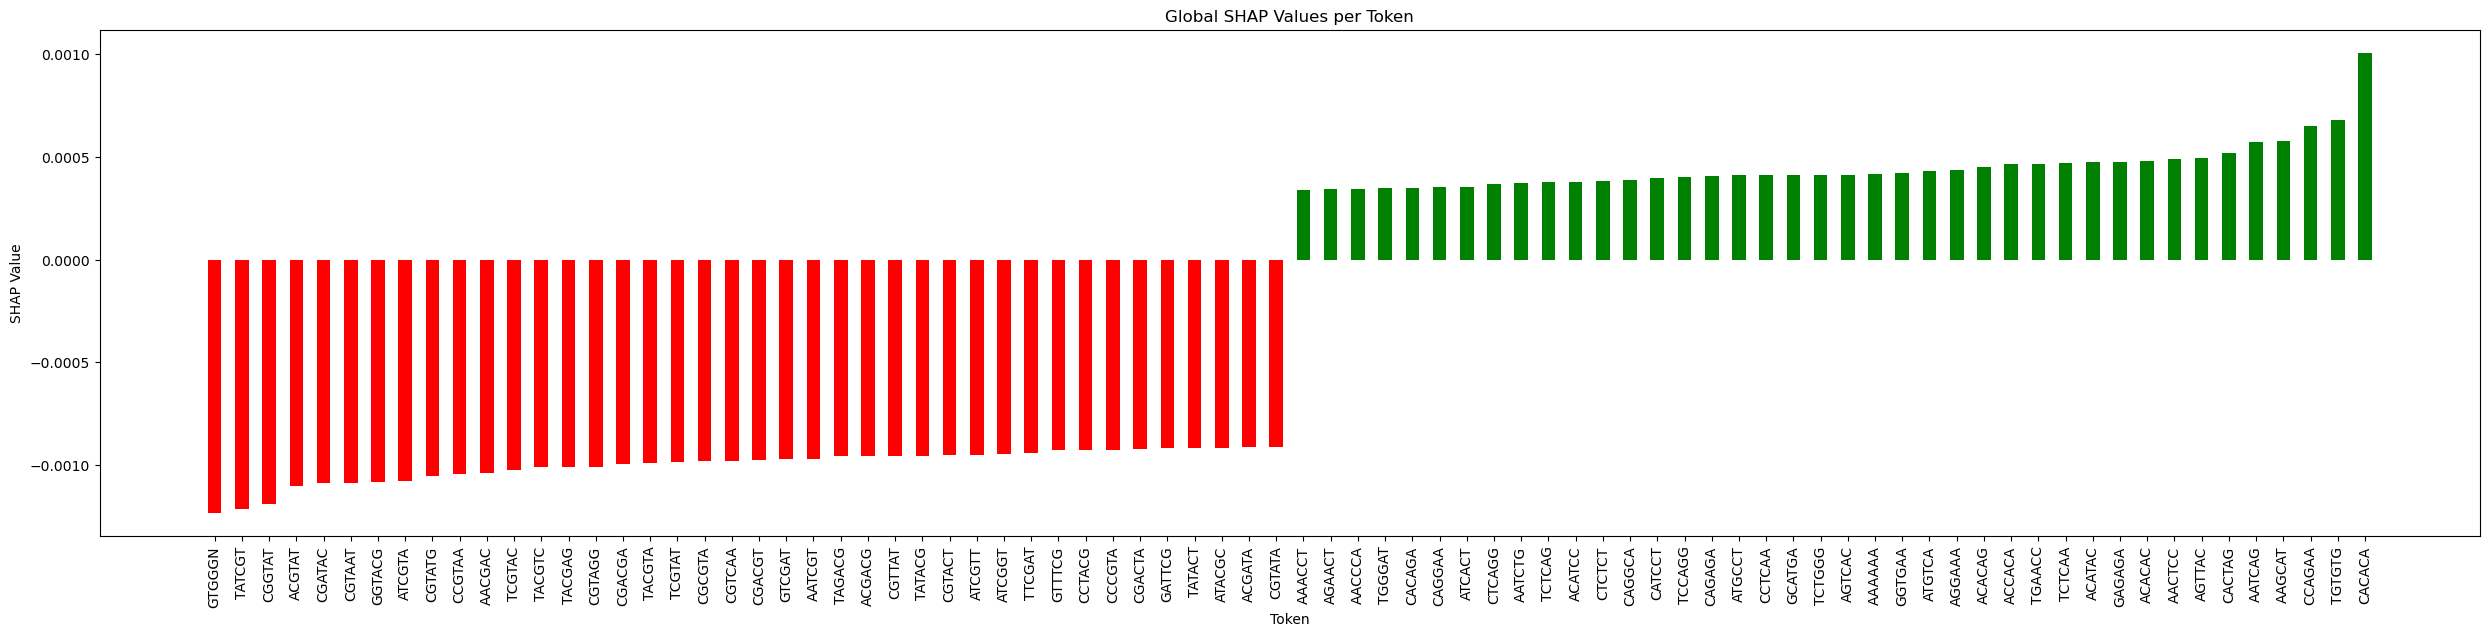

In [ ]:
plot_shap_values(combined_dict, "Global")

### Local SHAP

In [ ]:
def shap_values_local(record_num):
    """
    Computes and aggregates SHAP values for each token in a specific record,
    and then maps these tokens to their corresponding features.

    Args:
        record_num (int): The index of the record for which SHAP values are calculated.

    Returns:
        dict: A dictionary where keys are features (detokenized from tokens) and
              values are the aggregated SHAP values for those features.
    """
  shap_value_per_token = defaultdict(float)

  for j, token in enumerate(shap_values.data[record_num]):
    shap_value_for_token_in_seq = shap_values.values[record_num,j,1]
    shap_value_per_token[token] += shap_value_for_token_in_seq

  # Chnage keys from tokens to sub sequences features
  features_shap_value_dict = {}
  for key, item in shap_value_per_token.items():
    detokenized_feature = tokens_and_features_dict[key]
    features_shap_value_dict[detokenized_feature] = item

  del features_shap_value_dict['[PAD]']
  # # del features_shap_value_dict['[SEP]']
  # del features_shap_value_dict['[CLS]']

  return features_shap_value_dict

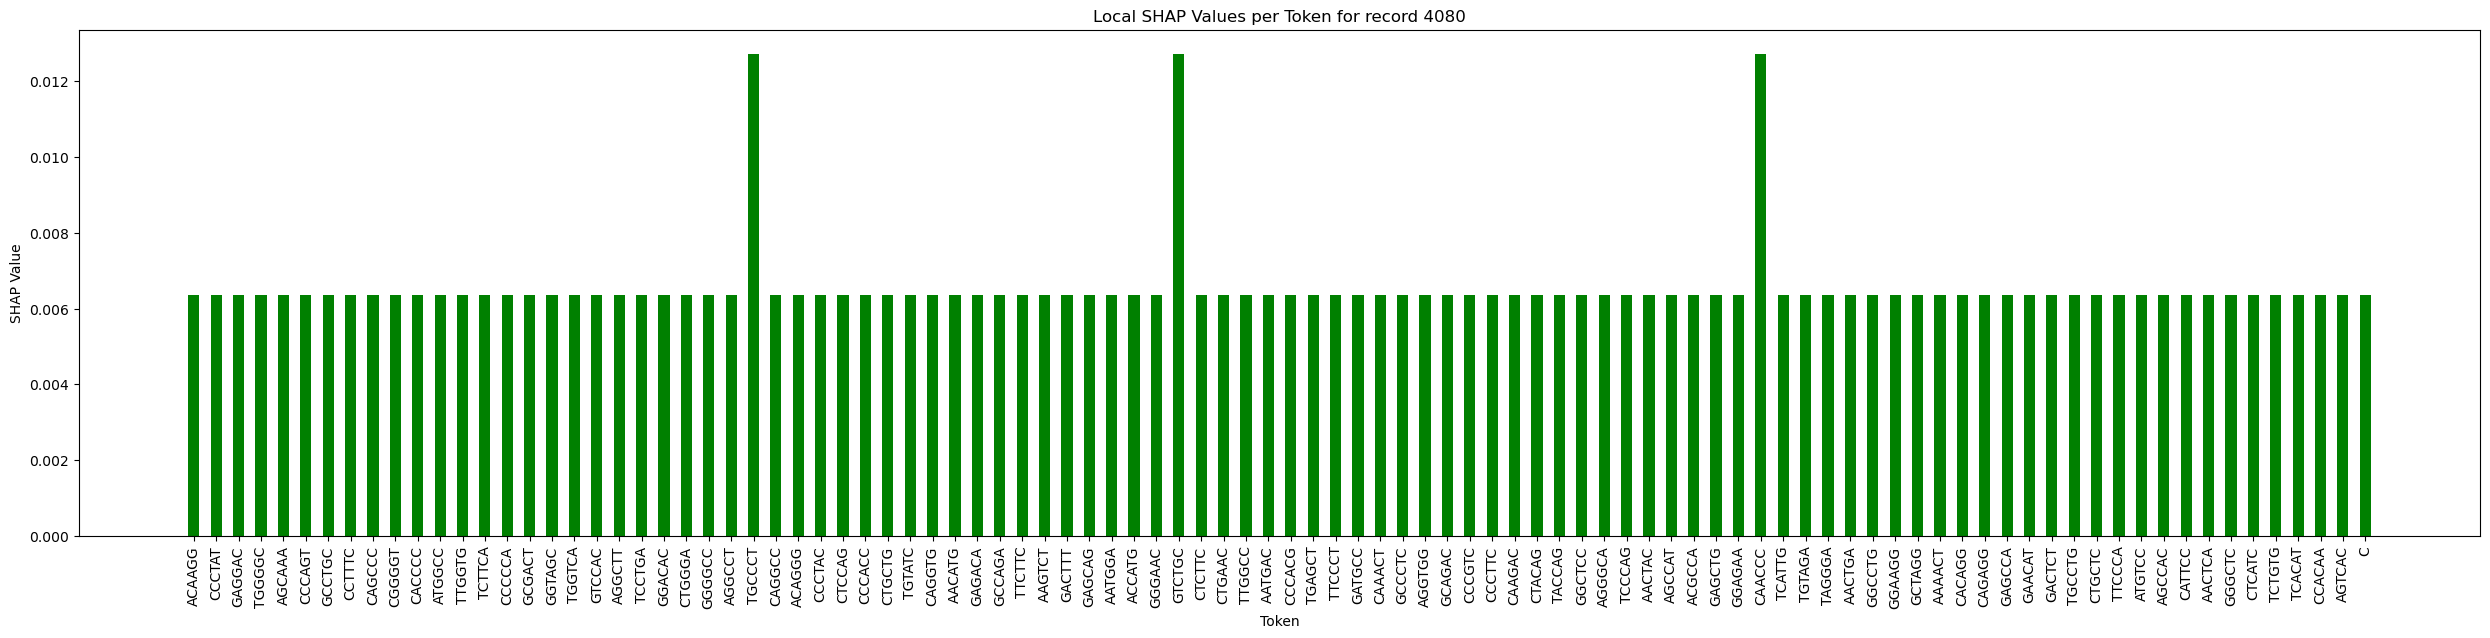

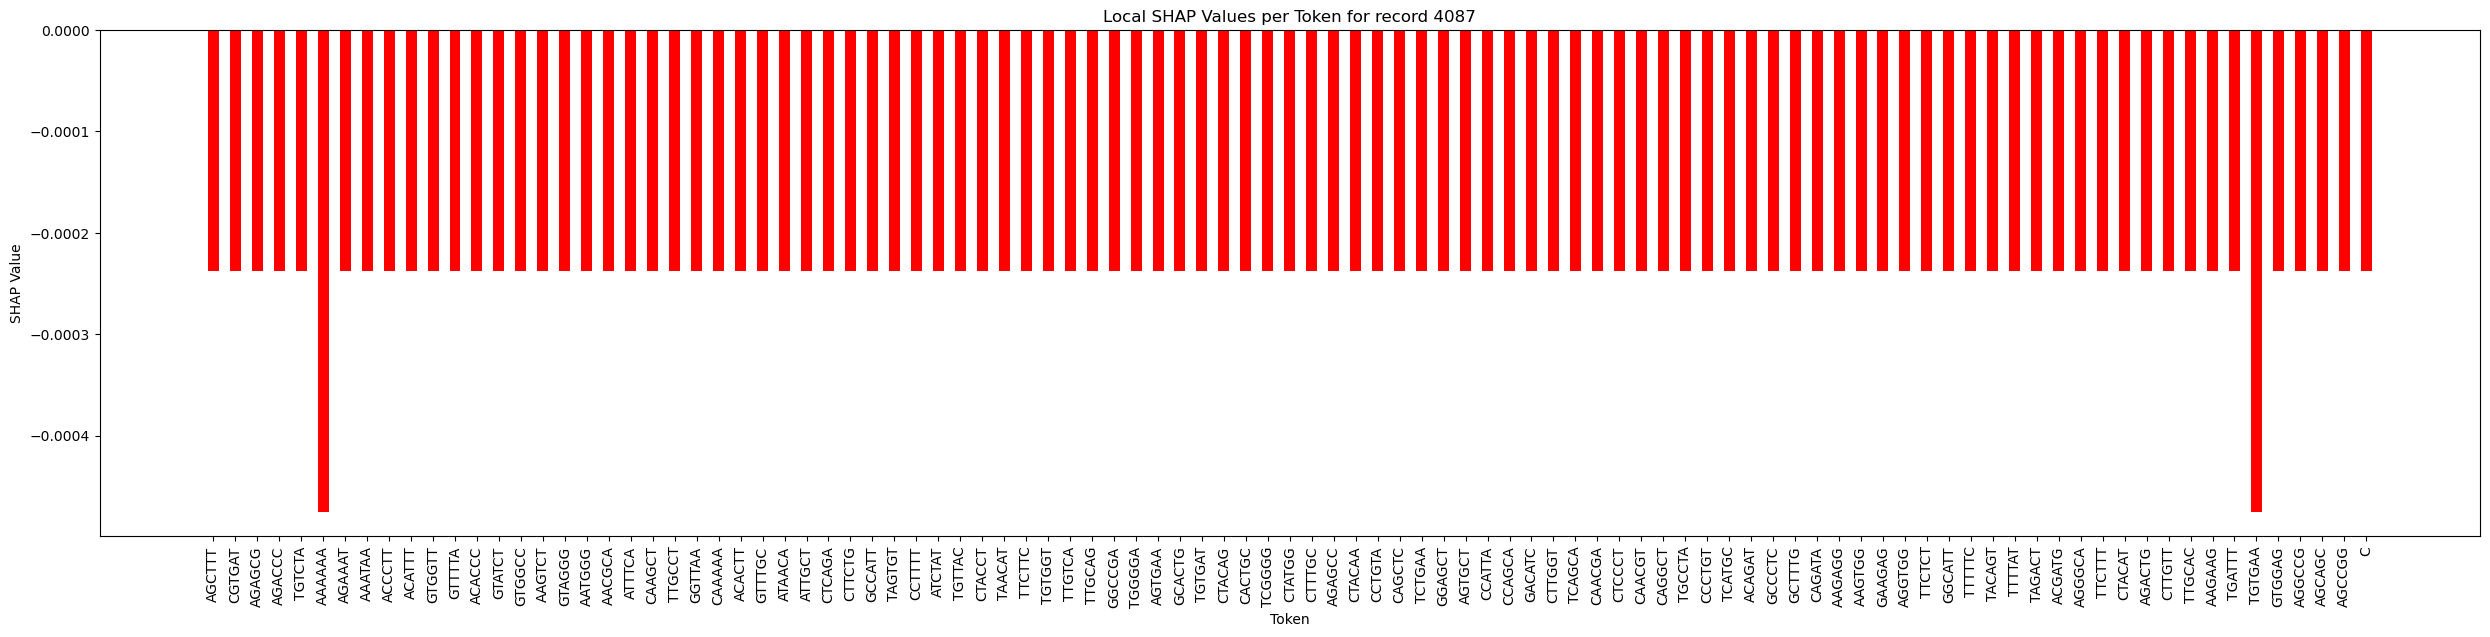

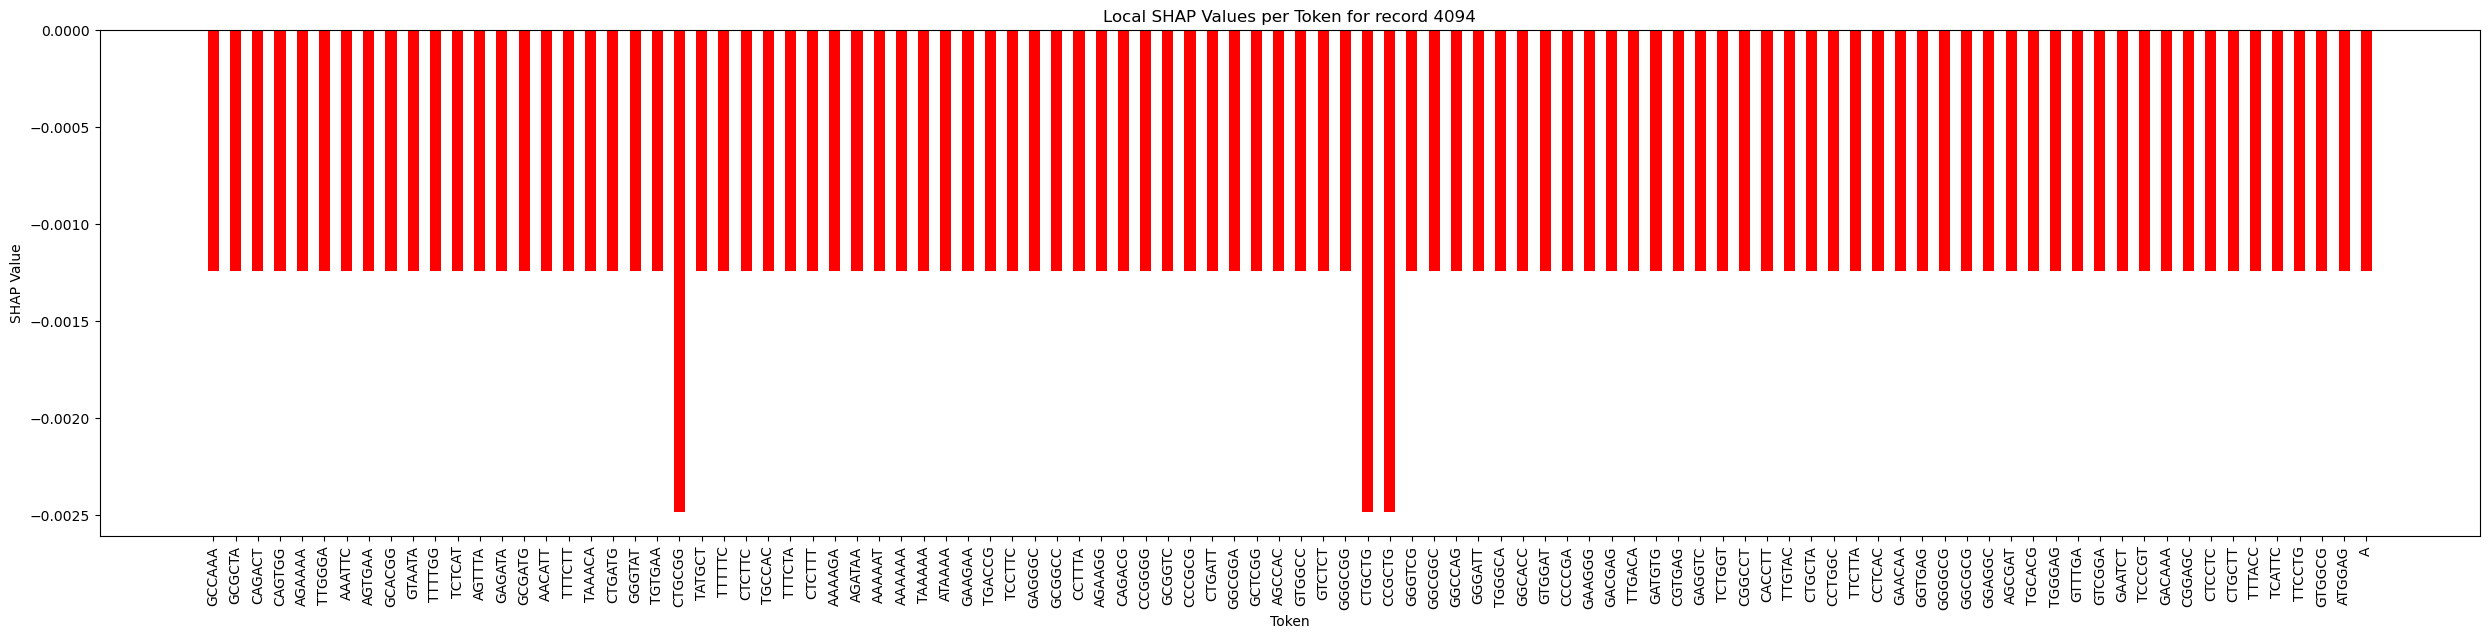

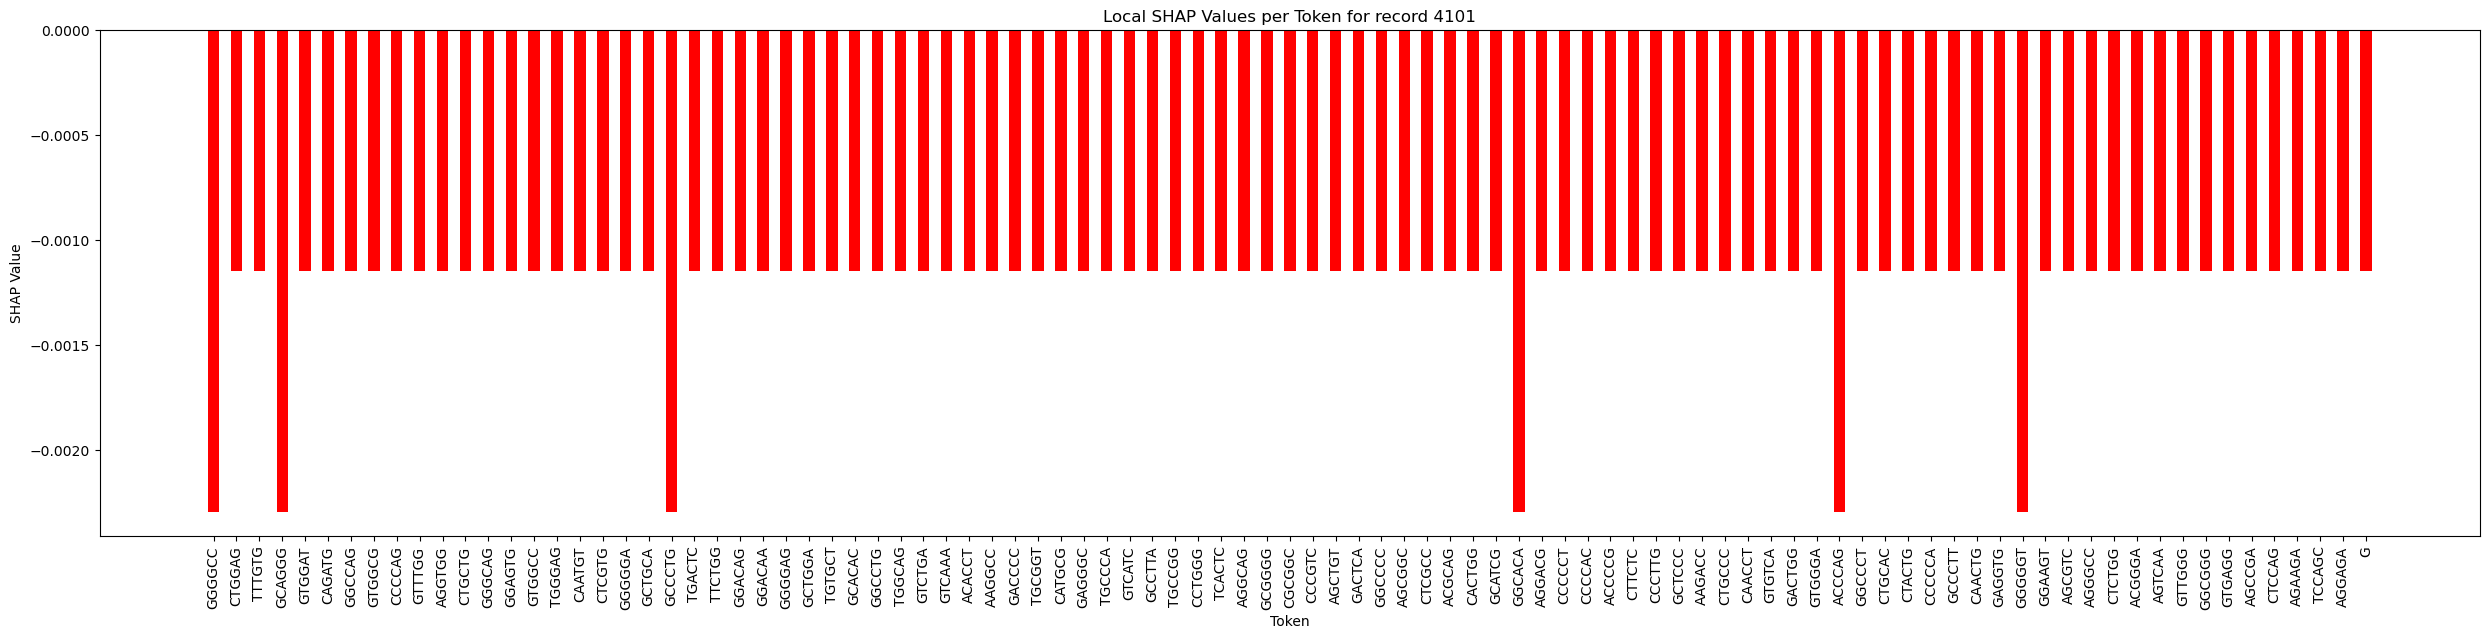

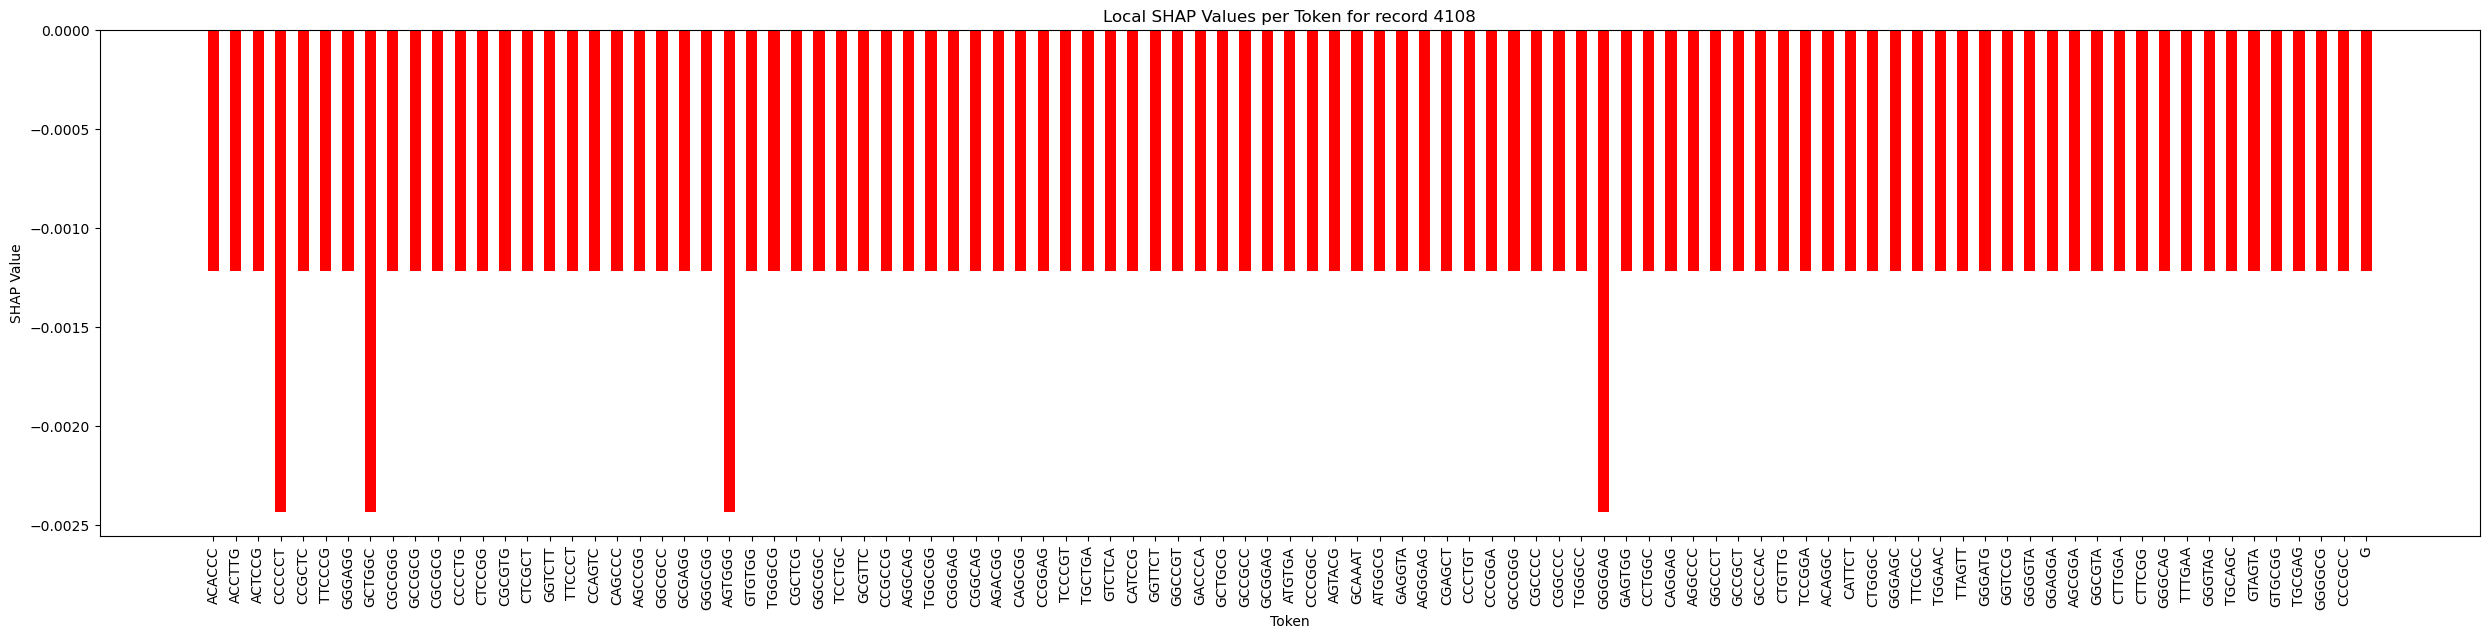

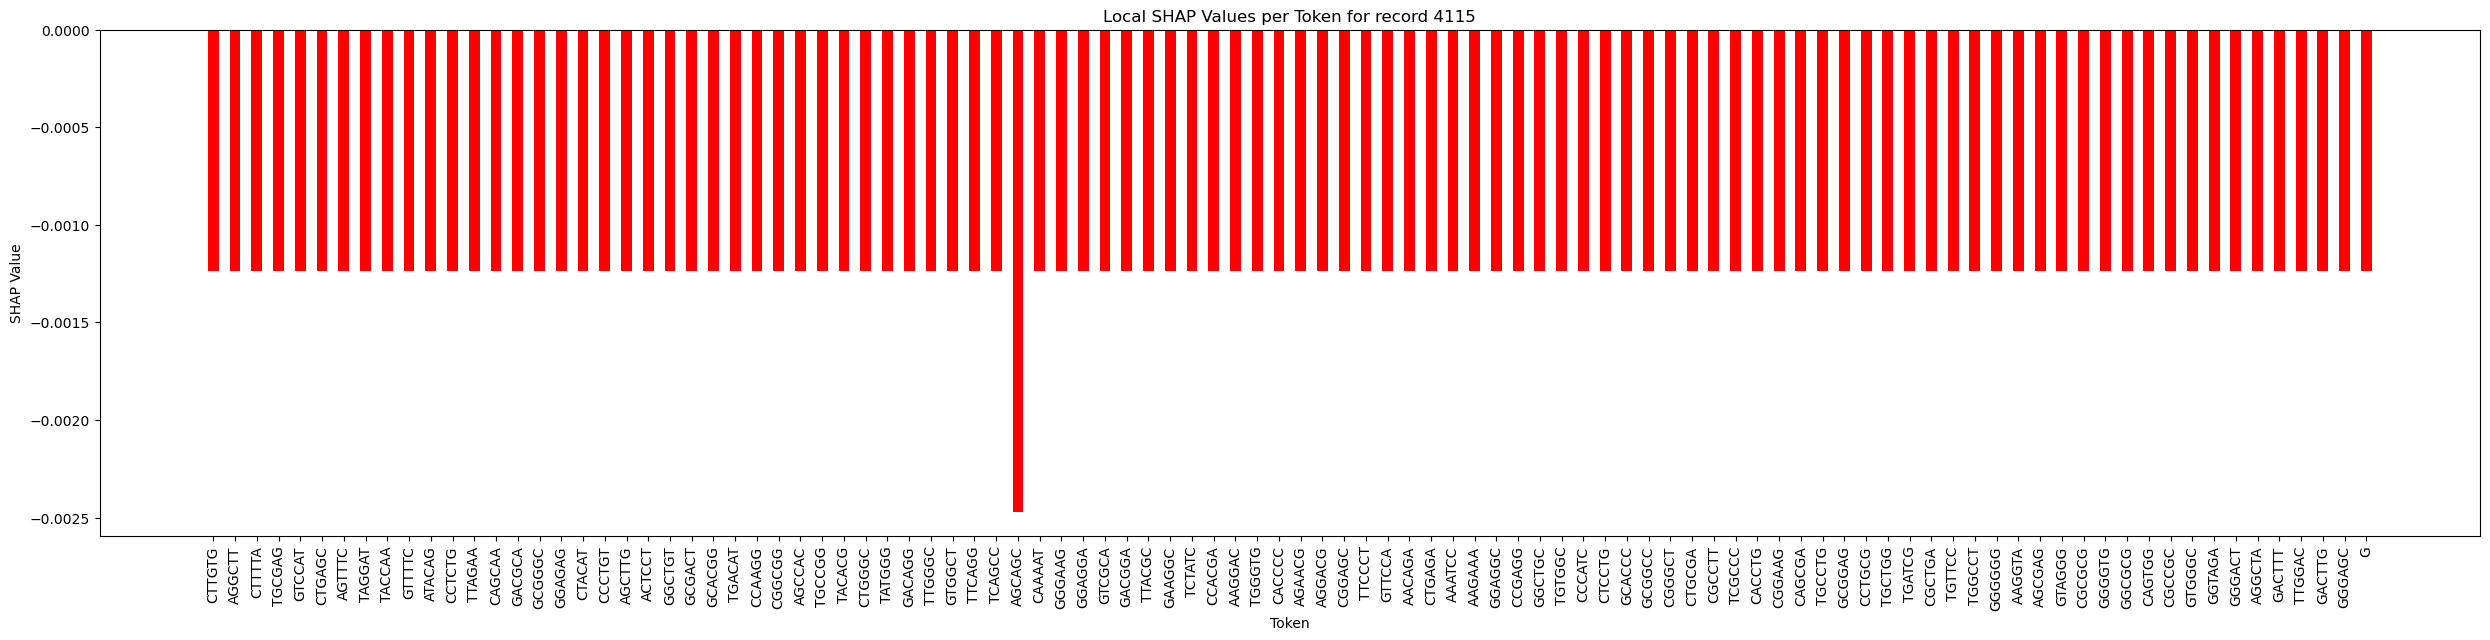

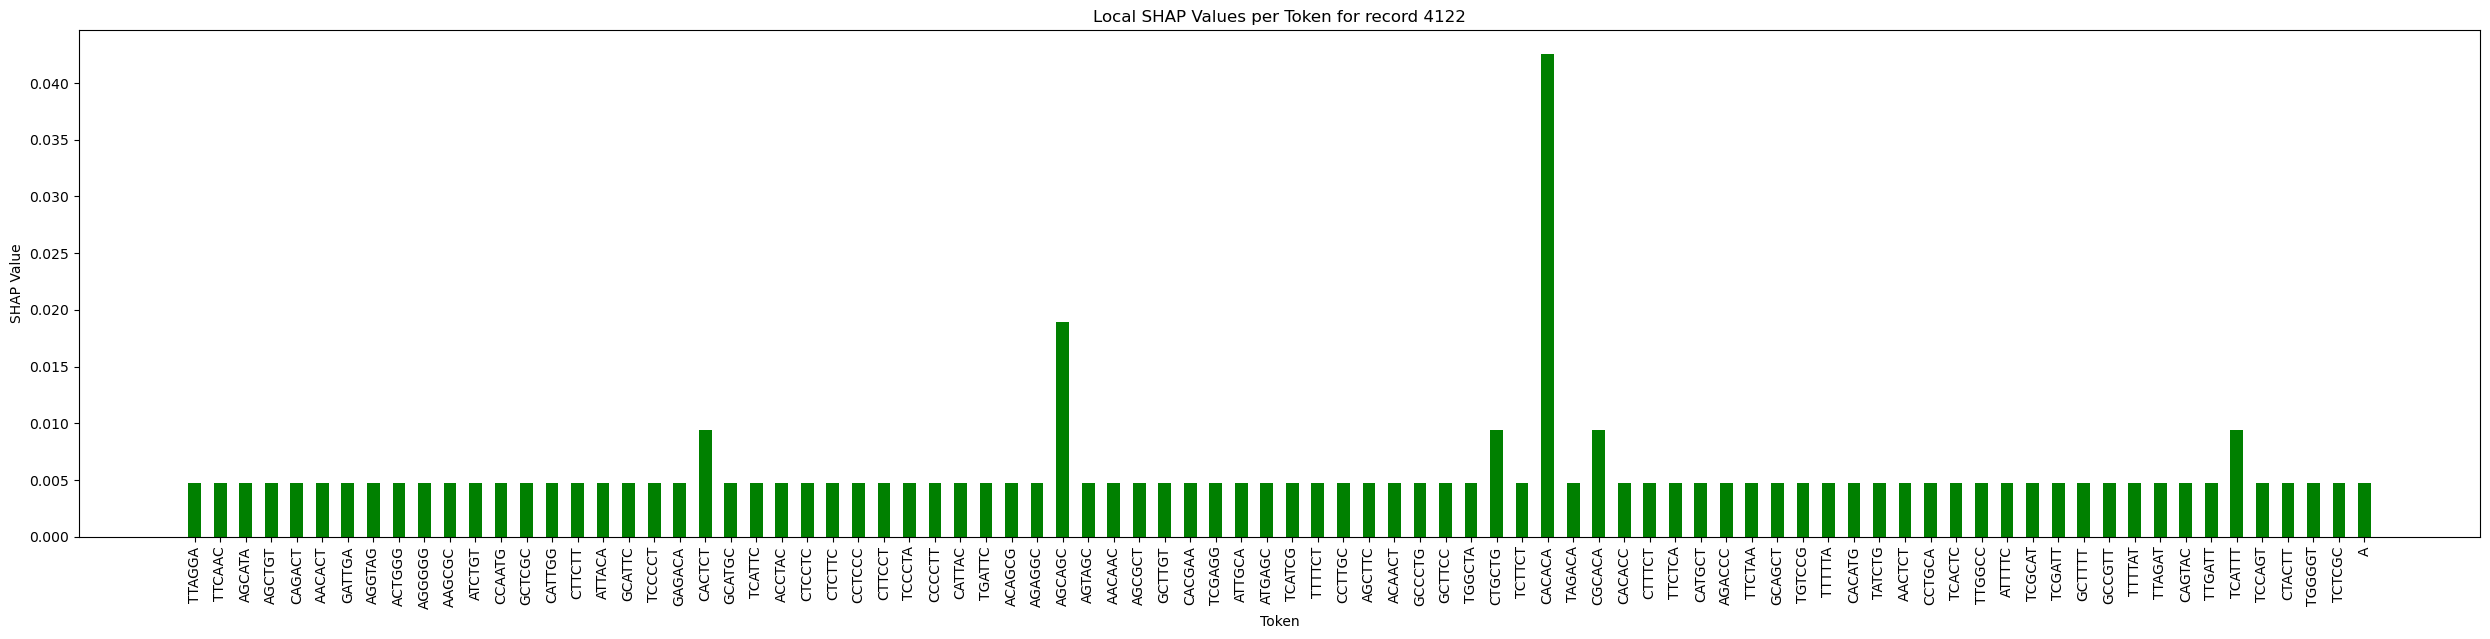

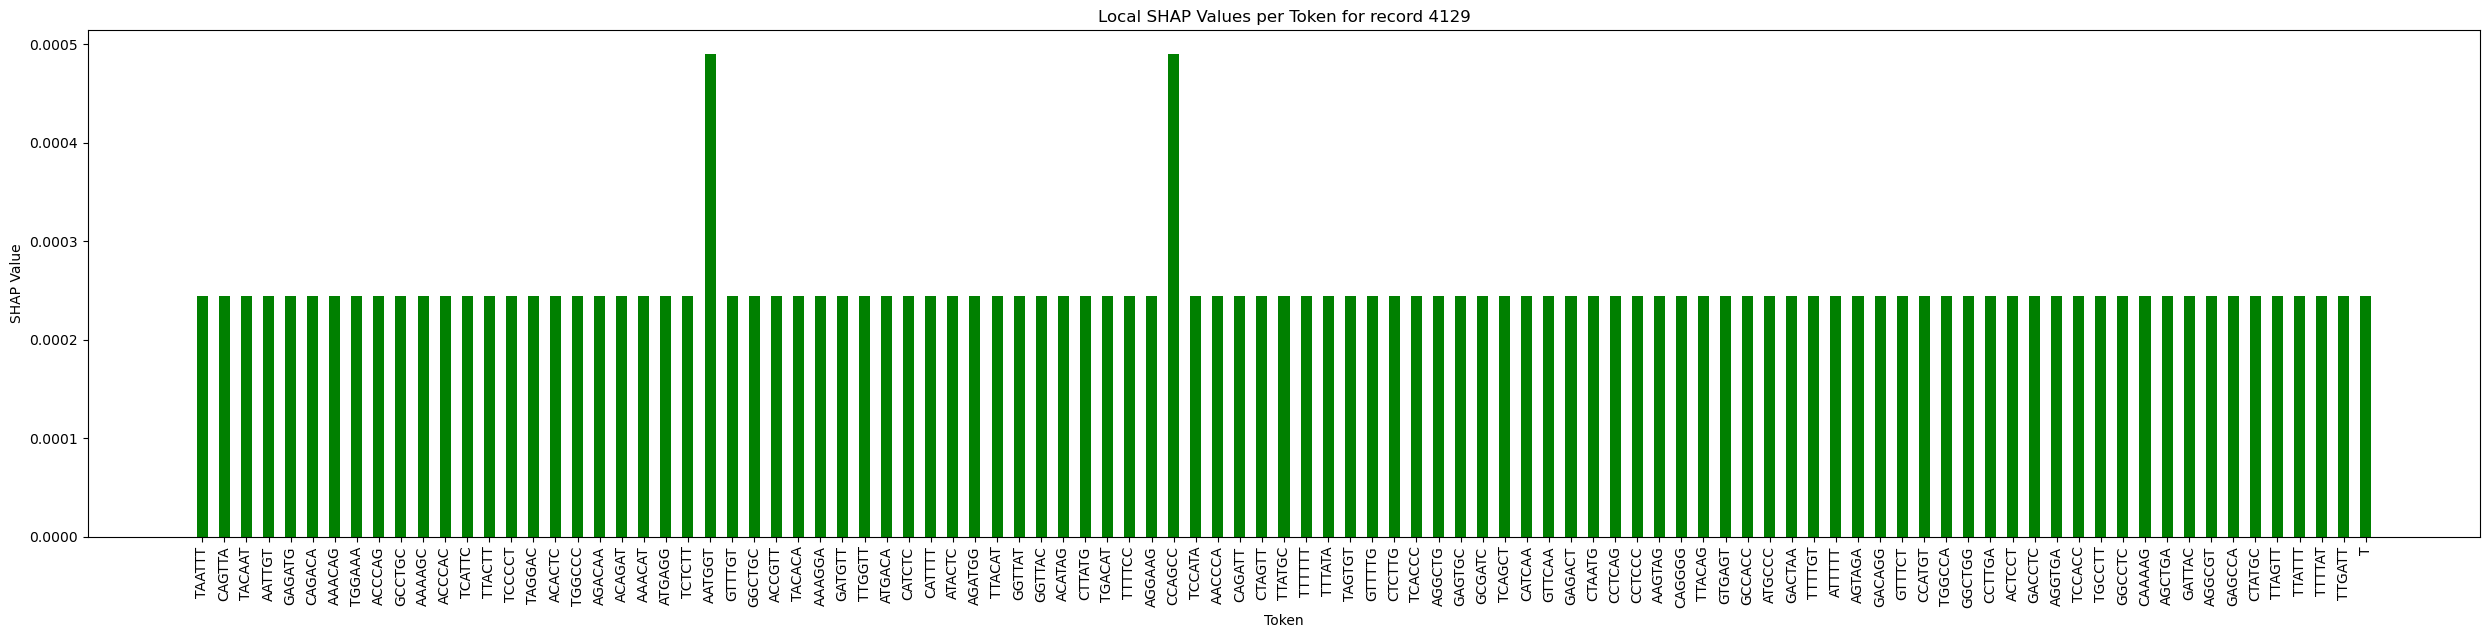

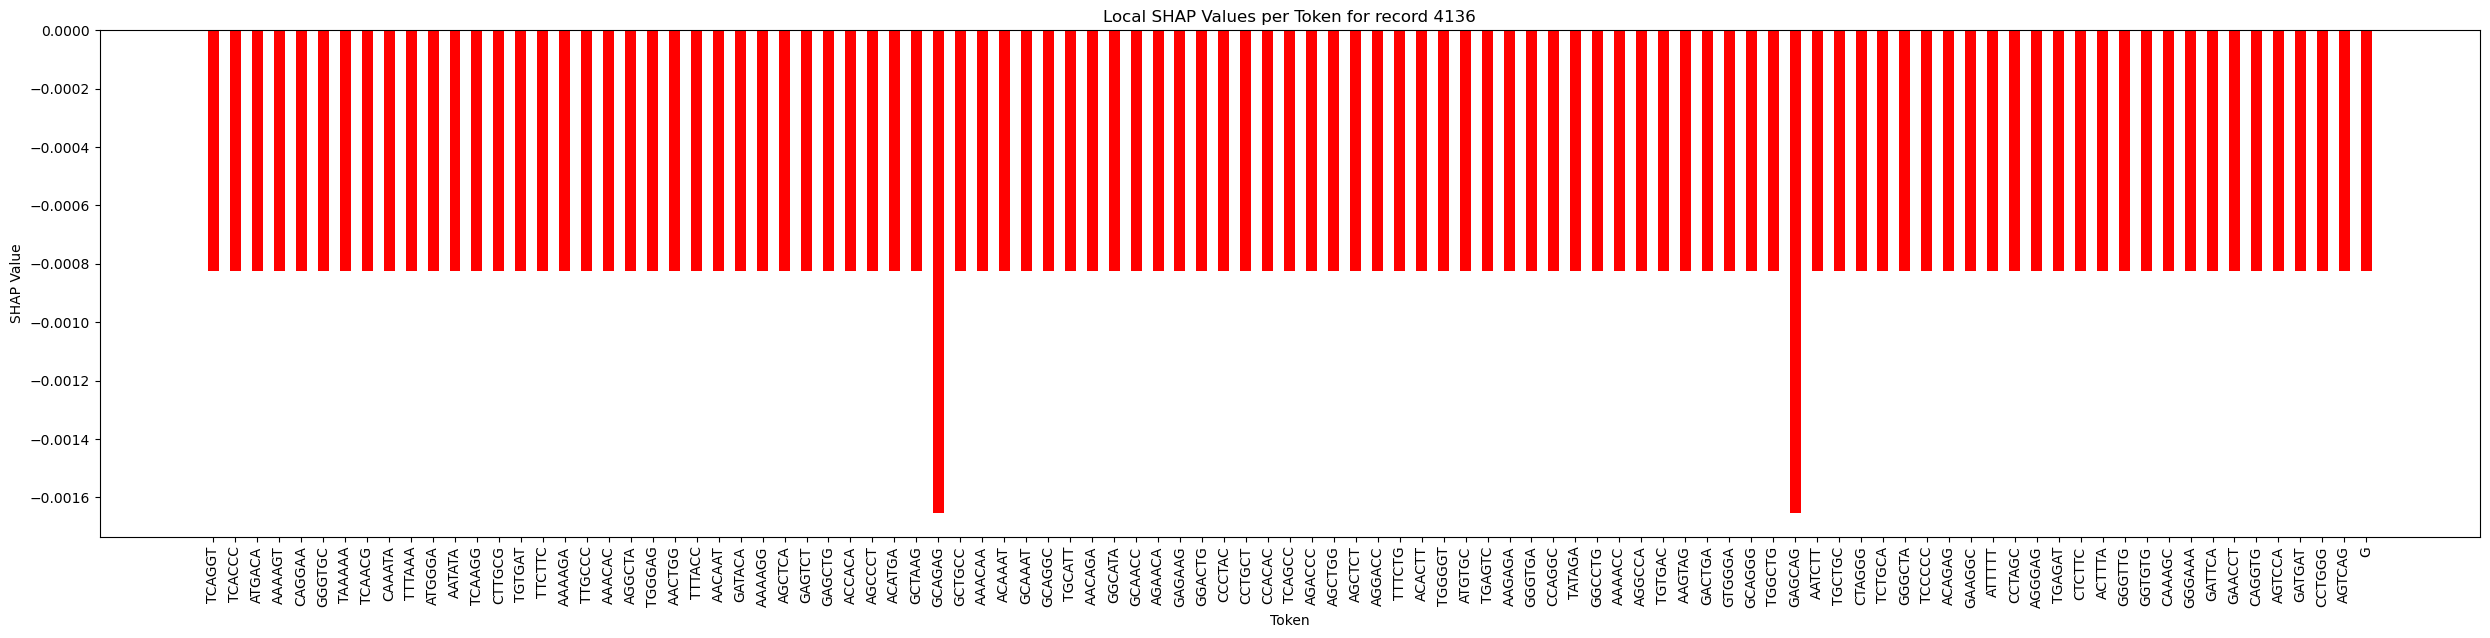

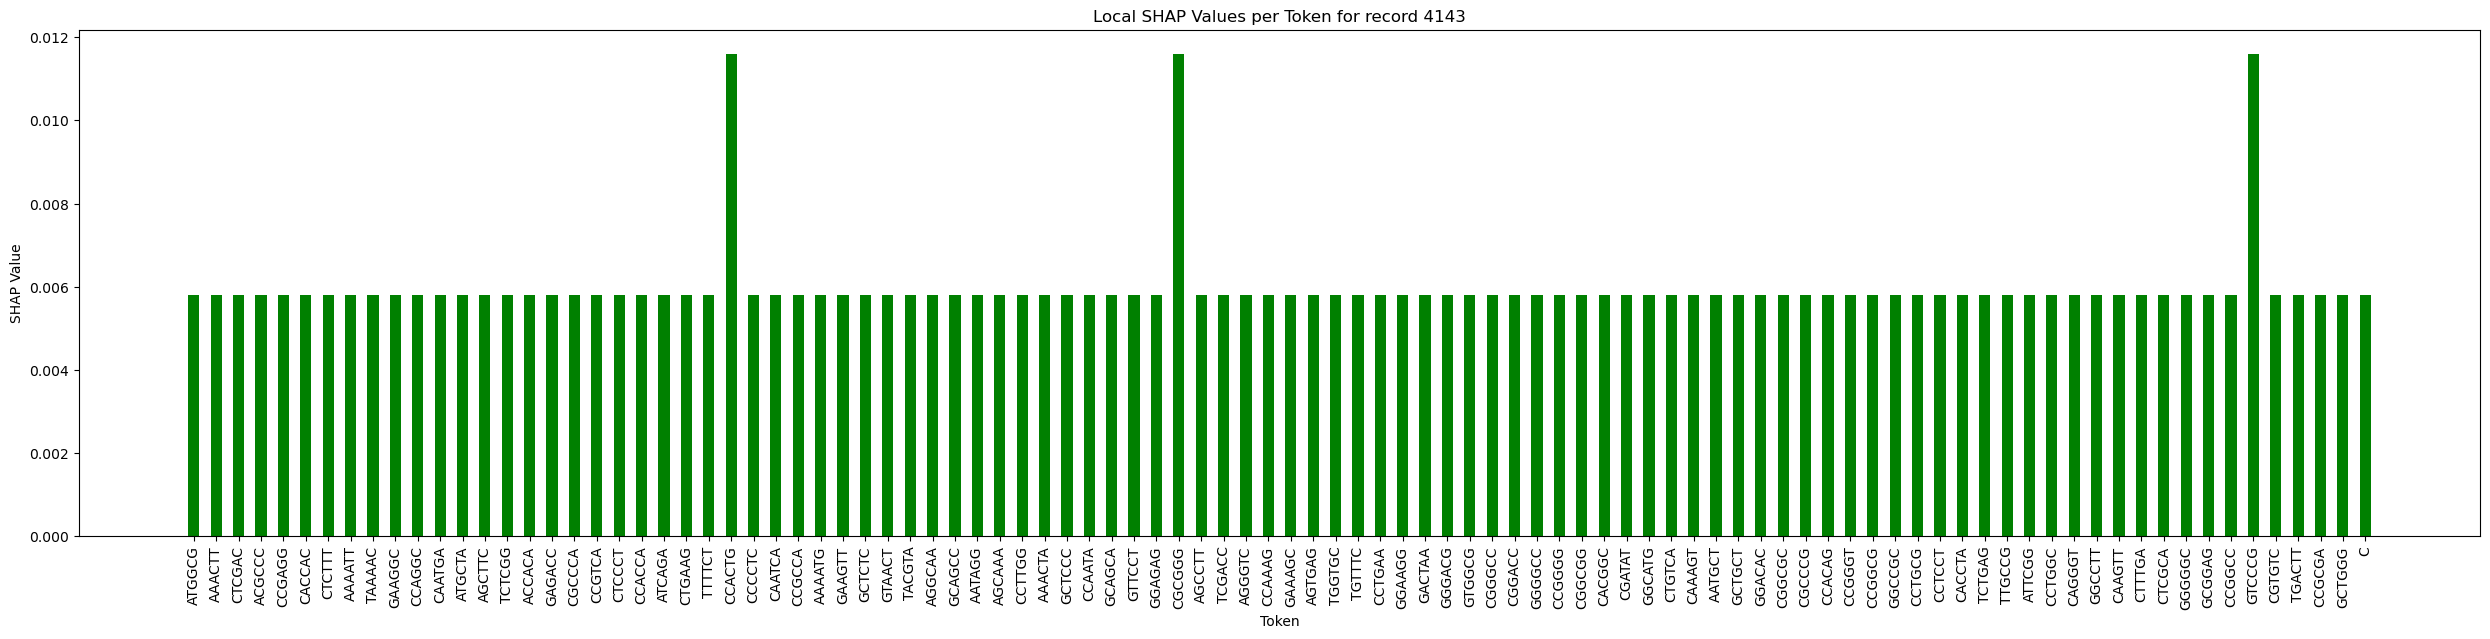

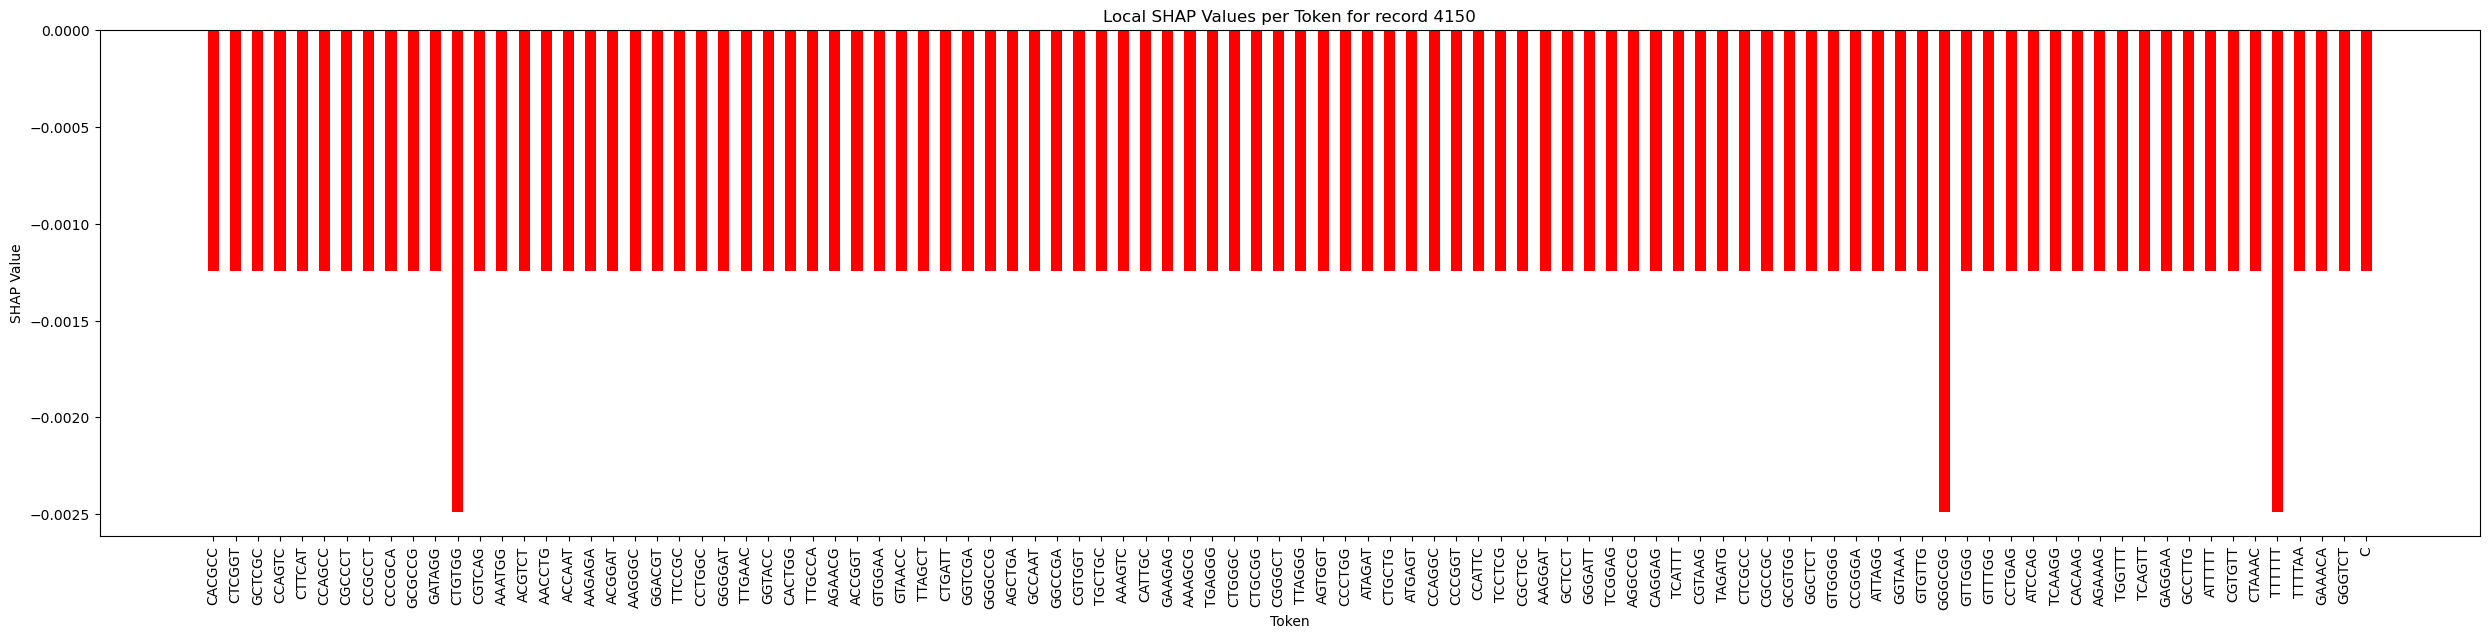

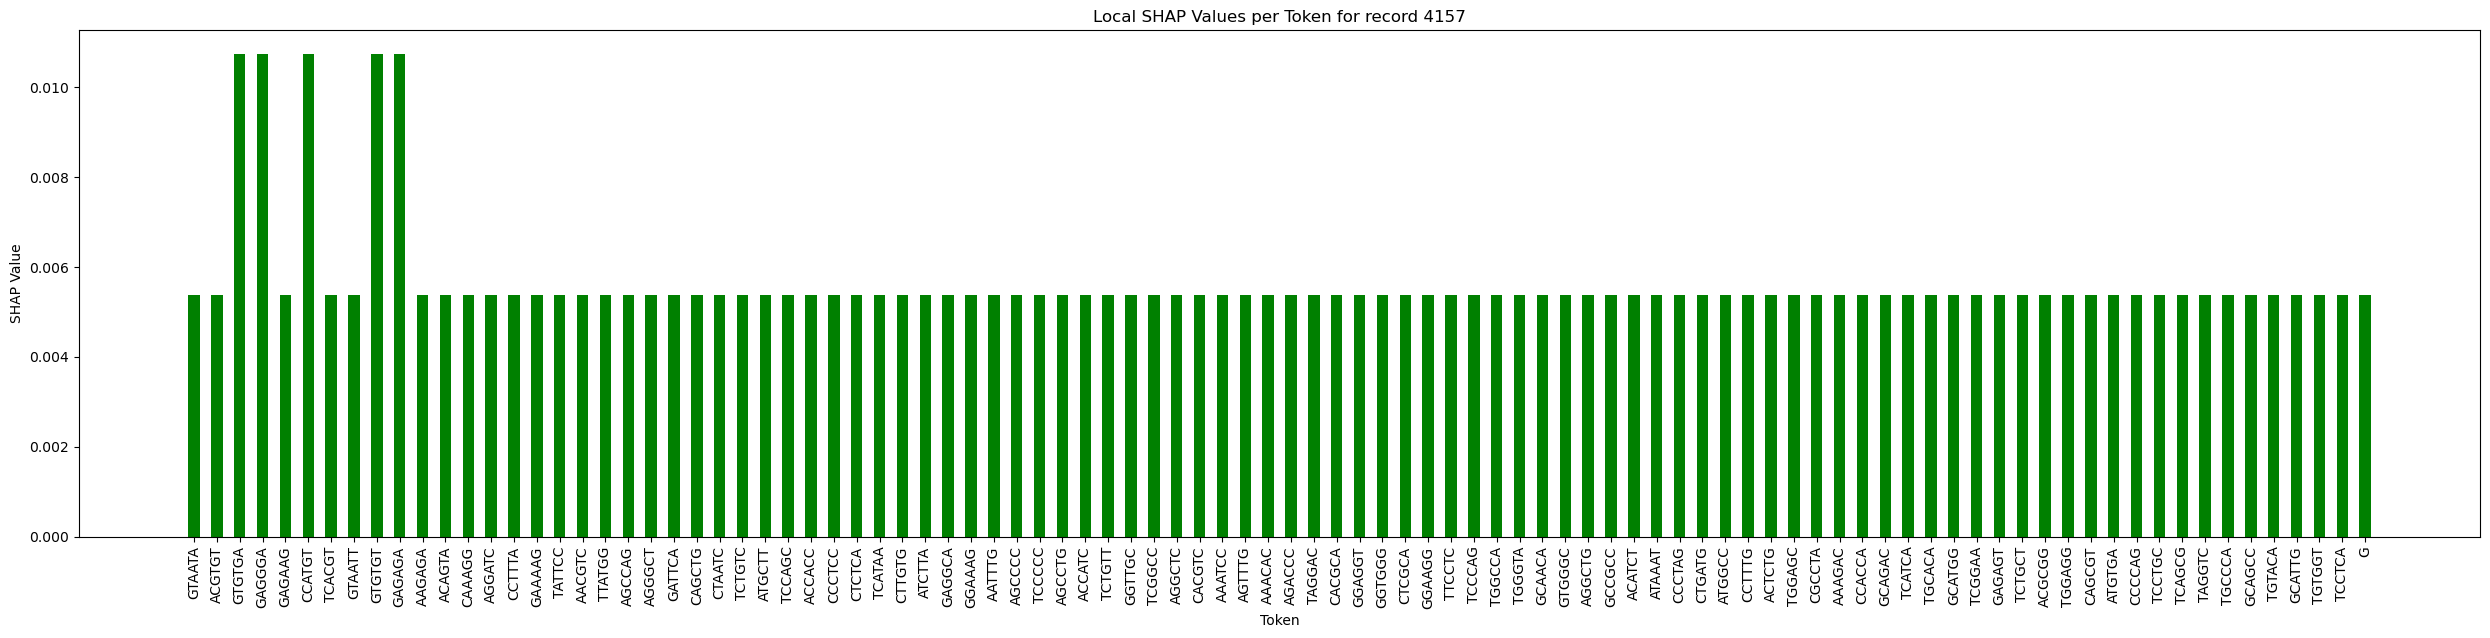

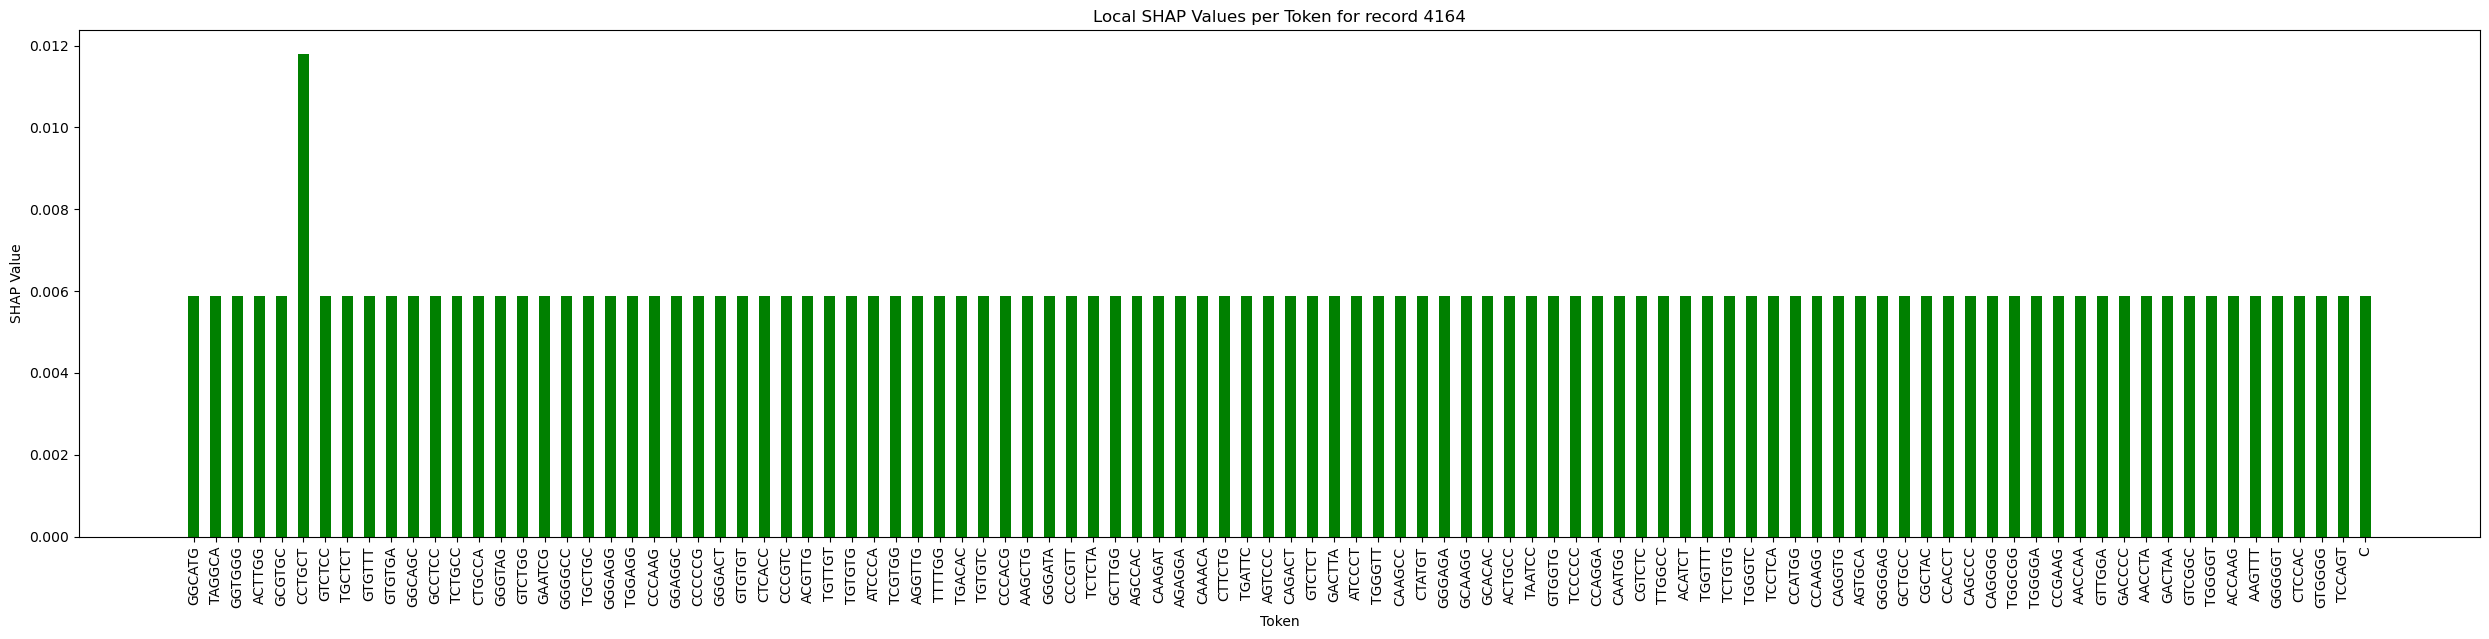

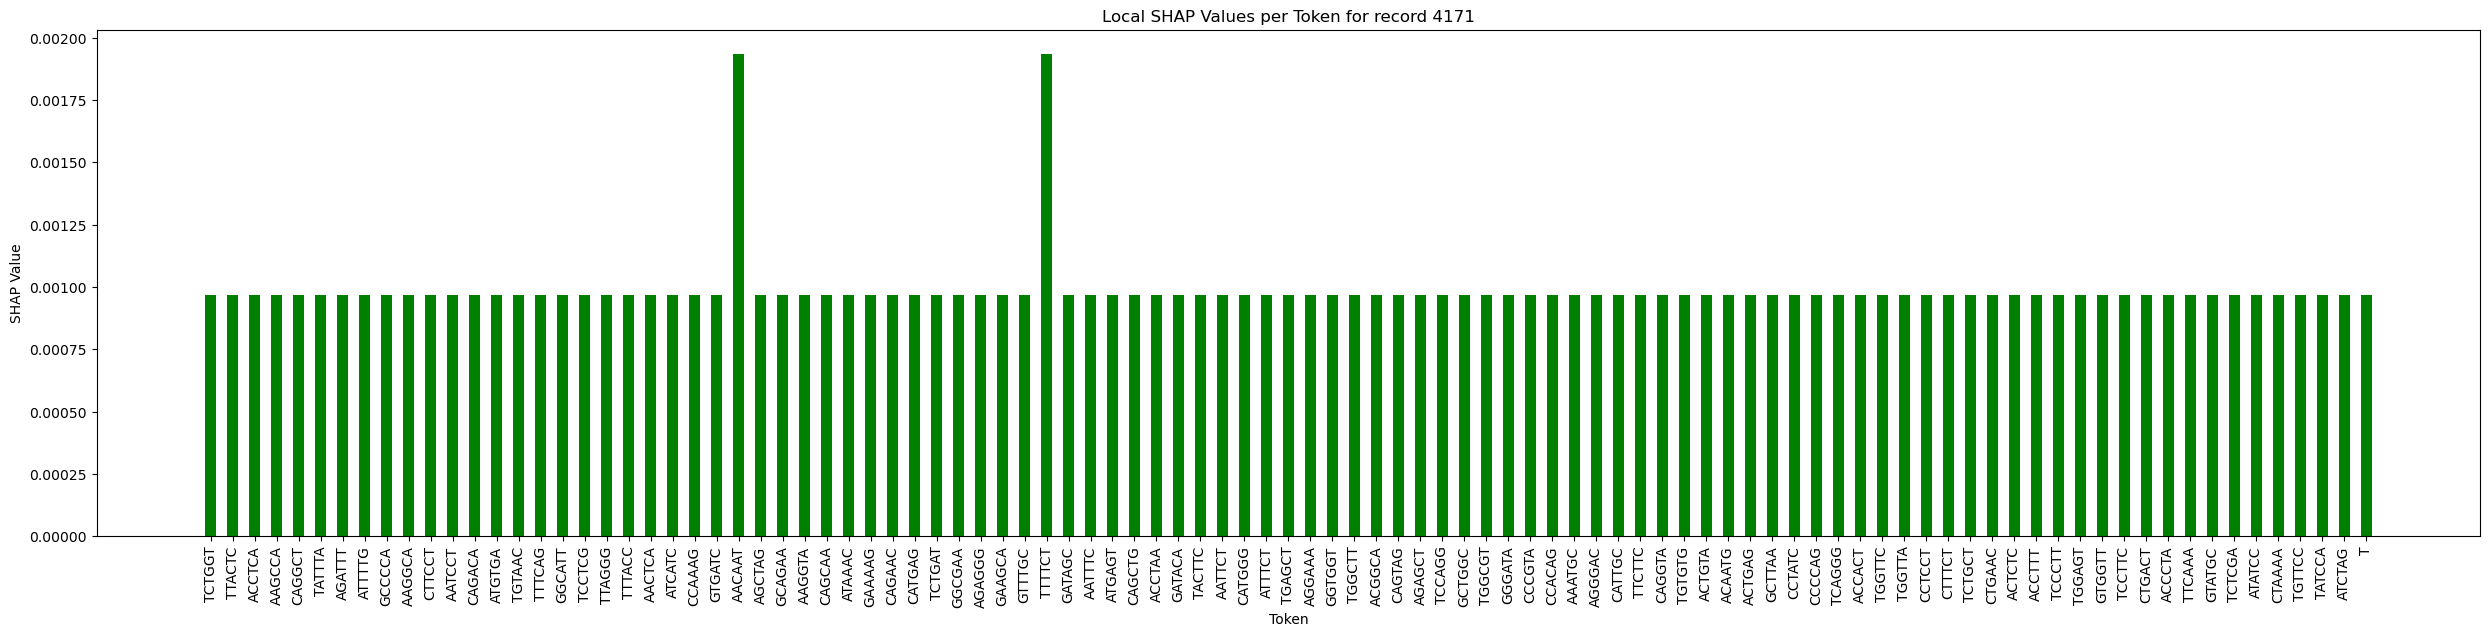

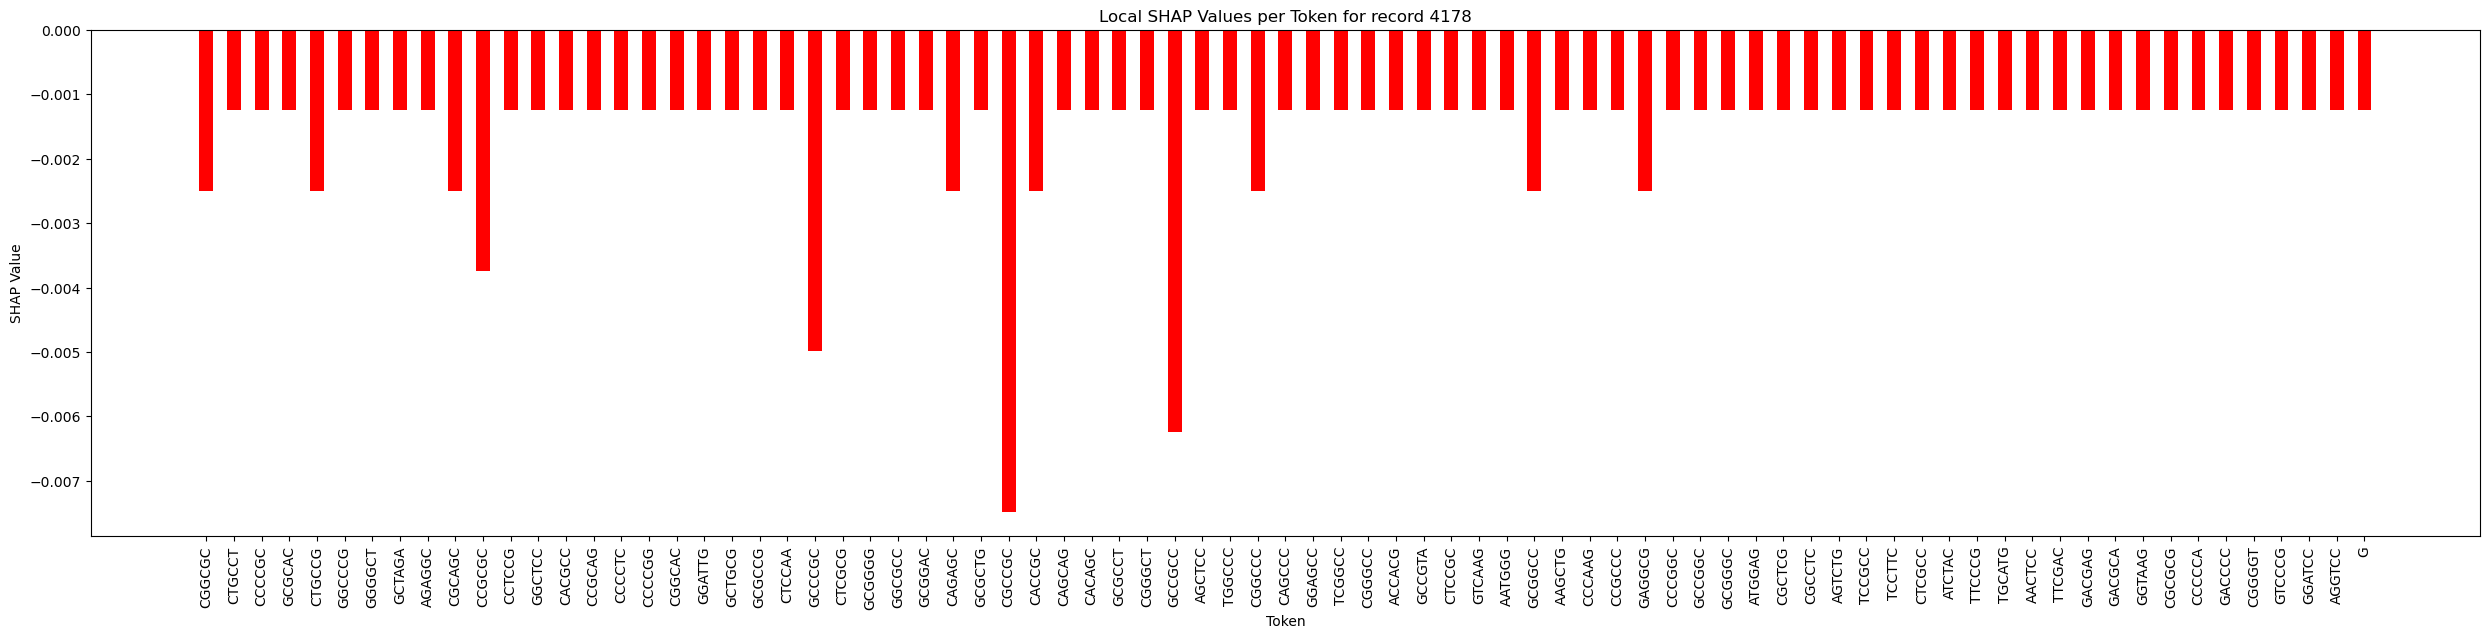

In [ ]:
for i in range(4080,4080+100,7):
    shap_values_record = shap_values_local(i)
    plot_shap_values(shap_values_record, "Local", record=i)